In [ ]:
# Suggested use of the notebook:
# Please run all cells before reading the report
# Please make use of the Markdown Expand/Contract functionality whenever navigating the notebook
# I suggest keeping all cells contracted,
    # until reading a specific section of findings
    # Suggestions and links to sections that should be expanded
    # are provided after relevant subtitles with a triple asteriks.
    # This will allow to use links/anchors to images, tables and sections
    # Most images were not included in the report main body, but can be accessed in relevant sections

<span style="font-family: Helvetica;">

# Executive Summary

**Introduction:**

This report addresses the critical need for predicting paediatric Emergency Department (ED) admissions, which account for a significant portion of hospital admissions. With EDs under increasing strain, predicting patient flow is essential for effective resource allocation. **The goal is to propose and evaluate a model for forecasting paediatric ED admissions over 28-day periods.**

**Methods:**

Historical daily paediatric ED admissions from 1<sup>st</sup> April 2014 to 19<sup>th</sup> February 2017 were analysed. The exploratory data analysis involved descriptive statistics and visualisations. A protected hold-out of 28 days was reserved for simnulated prospective model evaluation.

Various models were considered, including seasonal ARIMA, Prophet, and supervised feed-forward and LSTM neural networks. Model performance was evaluated using time-series cross-validation (TSCV) metrics such as mean squared error (RMSE), mean absolute percentage error (MAPE), 80% and 95% Prediction Intervals’ (PI) coverages, and Winkler scores.

**Findings & Expected Performance:**

Data showed non-normal distribution with seasonality patterns and surges in spring and autumn. Highest attendances were on Sundays and Mondays, with the lowest on Wednesdays. Autocorrelation indicated significant patterns up to the 16<sup>th</sup> day.

Benchmark models favoured the Average model. Among ARIMA models, ARIMA(14,0,1)(0,1,1,7) performed best. Basic Prophet outperformed ARIMA, and model improvements were achieved by adjusting trend flexibility and seasonality parameters. Neural networks did not outperform the Average model.

The best model was a Prophet model with a rigid trend, 15th-order Fourier seasonality, and influenza-like illness (ILI)-informed change-points based on surveillence data. Evaluation on the hold-out period showed RMSE of 7.41 (MAPE of 13.7), 80% and 95% PI coverages of 0.75 and 1, respectively. Overall, the performance was acceptable with sufficient uncertainty around predictions.

**Recommendation:**

- Prospective model evaluation in real-world setting is warranted, and models should be continuously re-evaluated for emerging trends 
- Proposed Prophet model can be used to predict monthly ED admission, if mean error of ±7 attendances (~14%)is acceptable
- Further exploration of ILI surveillance data, alongside more granular ED data by age and cause, could enhance predictions for paediatric ED admissions
</span>


In [2]:
################## Intentionally Left Blank ##################

## Introduction and Aims

The ED plays a central role in hospital admissions, with an estimated 50% originating in this department(1). Of these admissions, approximately 28% lead to hospitalization(1). Predicting ED patient flow is crucial for effective resource allocation, upstream and downstream hospital operations, and overall management. The Royal College of Emergency Medicine's recent report underscores the escalating strain on ED departments across the UK (2). Previous studies affirm the predictability of ED admission rates, contributing to enhanced resource planning(3). The primary objective of this report is to comprehensively evaluate candidate models for predicting paediatric ED admissions over the next 28 days.

1. [NHS England, _A&E Attendances and Emergency Admissions Statistical Commentary_, March 2023](https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2023/04/Statistical-commentary-March-2023-assefg.pdf)

2. [Royal College of Emergency Medicine, _What’s behind the increase in demand in Emergency Departments?_, August 2021](http://president.rcem.ac.uk/index.php/2021/08/06/whats-behind-the-increase-in-demand-in-emergency-departments/)

3. [Lystad, Reidar P., et al. _Incidence, trends, and seasonality of paediatric injury-related emergency department presentations at a large level 1 paediatric trauma centre in Australia._ _Trauma Care_ (2022): 408-417.](https://www.mdpi.com/2673-866X/2/3/33)


## Methods

We analysed historic daily paediatric ED admissions collected from a single centre from the 1st of April 2014 to the 19th of February 2017. We performed exploratory data analysis utilising descriptive statistics, exponentially weighted means, and visualising data variation for different timeframes. Autocorrelation and partial autocorrelation were visualised, and Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test was performed to evaluate for stationarity around a constant or a trend.

A protected hold-out of 28 days was set aside from the onset for the proposed model evaluation of predicted real-world performance. The remaining data were split into training and testing (validation) splits using 75% of the data for training.

Models predicting 28 days into the future were considered. Models were trained using rolling-origin time-series cross-validation (TSCV) on the training split, and metrics were calculated using TSCV of 6 folds separated by a 14-day spacer ([_See_ Testing in Section 3](#tscv)). All models were evaluated using identical TSCV folds to facilitate comparison across models. Evaluation metrics included root mean squared error (RMSE), prediction intervals’ (PI) coverages, and Winkler scores for 80% and 95% PIs. Additionally, mean absolute percentage error (MAPE) was included to allow comparison with previously published literature.

Candidate models included a naïve Average model, seasonal ARIMA, and Prophet, in various configurations. First, a seasonal ARIMA was selected based on Akaike’s Information Criterion (AIC) as implemented in the auto_arima() method from the PMDARIMA package with default parameters. Then, we explored additional seasonal ARIMA models first by changing the parameters optimisation from stepwise to a grid-search, and second by removing constraints of default maximal values for the order of moving average, differencing, and auto-regressive lags for both seasonal and non-seasonal components. Lastly, based on the KPSS test, we adjusted the order of the auto-regressive time-lags to include either a week or two weeks of time-lags for the non-seasonal component.

For Prophet models, we initially started with default model parameters as a Prophet benchmark and attempted to improve it in an iterative way. Then, we evaluated a Prophet model with a less flexible trend by adjusting the change_point_prior_scale. Similarly, we adjusted the Fourier Order for seasonality to allow for a more precise fit. Lastly, we considered including changepoints based on the historical data from Public Health England's Surveillance of Influenza and Other Respiratory Viruses in the UK from 2014 to 2017 (4). Namely, we used the General Practitioner (GP) Influenza-like illness (ILI) consultation rate as a proxy measure of ILI seasonality. For each season, we included two changepoints – the start of the flu season, defined as doubling the baseline ILI GP consultation rate; and the end of the flu season, defined as a 50% reduction from the maximum consultation rate for that year.

Additionally, supervised feed-forward and long short-term memory (LSTM) neural networks (NN) predicting the forecast as a vector were explored with various architectures, including drop-out layers, the number of layers, and neurons.

4. [Public Health England, Annual Flu Reports (Archived), June 2021](https://webarchive.nationalarchives.gov.uk/ukgwa/20220401215804/https:/www.gov.uk/government/statistics/annual-flu-reports)

## Findings & Discussion

Based on the Shapiro-Wilk test, data were not normally distributed (P=0.0022) with a slight positive skewness (0.23), potentially attributable to an overall positive trend reported elsewhere (1,2). Highest 0.5% of data (n=8) were observed in July (n=1), December (n=1),  March (n=3), May (n=1), late November (n=2). The lowest 0.5% both were reported in August (n=2). Plotting daily and weekly ranges revealed seasonality with surges in early spring and late autumn, and troughs in July to September and then December-January (_See_ [Exploratory Data Analysis](#12)), consistent with published research (3). Similarly, plot by a weekday revealed the highest attendance on Sunday and Monday and the lowest on Wednesday. Autocorrelation plots revealed significant autocorrelation up to day 16th day and the 21st day. Partial autocorrelation was significant for up to and including 7 days. KPSS test around constant performed on all data did not reveal significant stationarity deviation from constant (P>0.1, Statistic=0.33, P=0.1 critical value of 0.347) or stationarity deviation around a trend (P>0.1, Statistic=0.07, P=0.1 critical value of 0.12).

#### Benchmark
*** [_Please expand top layer of Section 3_](#13)

Benchmark models were considered based on a range of metrics, including MAPE, RMSE, and MAE, and across all metrics, calculated through TSCV of training data, the Average model was suggested. Upon evaluating the Average model on testing (validation) split, the mean RMSE was 9.31, and MAPE was 15.0 [(_See Section 3.1)](#3.1).


#### ARIMA Model Evaluation
*** [_Please expand top layer of Section 4_](#14)

Six ARIMA models were considered (_[See ARIMA Plots](#arima_plots)_). All six models performed similarly, with RMSE ranging from 7.73 to 7.47 for ARIMA(0,1,1)(0,0,2,7) and ARIMA(14,0,1)(0,1,1,7), respectively. The former was generated by an initial constrained auto_arima call, while the latter was guided by the KPSS test and AC plots.

Neither grid-search nor unconstrained auto_arima models significantly outperformed the initial suggestion by auto_arima. The most significant improvement in RMSE and Winkler’s scores came from increasing the non-seasonal auto-regressive order. The best ARIMA model was of order (14,0,1)(0,1,1,7), with an RMSE of 7.47, PI coverage of 0.88 and 0.95, and Winkler’s scores of 30.0 and 43.0 for 80% and 95% PI, respectively.

Interestingly, both ARIMA models with increased non-seasonal auto-regressive order (either 7 or 14) demonstrated significantly better MAPE (11.75 and 11.83) compared to all other ARIMAs (ranging from 12.5 to 12.66). Mean TSCV metrics for all ARIMAs are presented below.


3. [Lystad, Reidar P., et al. _Incidence, trends, and seasonality of paediatric injury-related emergency department presentations at a large level 1 paediatric trauma centre in Australia._ _Trauma Care_ (2022): 408-417.](https://www.mdpi.com/2673-866X/2/3/33)

<table>
  <thead>
    <tr>
      <th>Model</th>
      <th>MAE</th>
      <th>MAPE</th>
      <th>RMSE</th>
      <th>Coverage_80</th>
      <th>Coverage_95</th>
      <th>Winkler_Score_80</th>
      <th>Winkler_Score_95</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Average()_avg</td>
      <td>7.502</td>
      <td>15.001</td>
      <td>9.310</td>
      <td>0.798</td>
      <td>0.958</td>
      <td>34.585</td>
      <td>48.145</td>
    </tr>
    <tr>
      <td>ARIMA(0,1,1)(0,0,2)[7] _avg</td>
      <td>6.304</td>
      <td>12.655</td>
      <td>7.728</td>
      <td>0.850</td>
      <td>0.950</td>
      <td>29.523</td>
      <td>41.616</td>
    </tr>
    <tr>
      <td>ARIMA(0,1,1)(2,0,0)[7] _avg</td>
      <td>6.296</td>
      <td>12.627</td>
      <td>7.728</td>
      <td>0.850</td>
      <td>0.950</td>
      <td>29.541</td>
      <td>41.632</td>
    </tr>
    <tr>
      <td>ARIMA(7,0,1)(0,1,1)[7] _avg</td>
      <td>6.049</td>
      <td>11.753</td>
      <td>7.502</td>
      <td>0.883</td>
      <td>0.950</td>
      <td>29.274</td>
      <td>43.309</td>
    </tr>
    <tr>
      <td>ARIMA(14,0,1)(0,1,1)[7] _avg</td>
      <td>6.071</td>
      <td>11.827</td>
      <td>7.467</td>
      <td>0.883</td>
      <td>0.950</td>
      <td>28.839</td>
      <td>41.896</td>
    </tr>
    <tr>
      <td>ARIMA(1,1,1)(1,1,1)[7] intercept_avg</td>
      <td>6.332</td>
      <td>12.501</td>
      <td>7.930</td>
      <td>0.850</td>
      <td>0.933</td>
      <td>30.010</td>
      <td>43.011</td>
    </tr>
    <tr>
      <td>ARIMA(0,1,1)(0,0,4)[7] _avg</td>
      <td>6.228</td>
      <td>12.525</td>
      <td>7.654</td>
      <td>0.850</td>
      <td>0.950</td>
      <td>29.029</td>
      <td>40.995</td>
    </tr>
  </tbody>
</table>


#### Prophet Models
*** [_Please expand top layer of Section 5_](#15)

The initial Prophet model substantially outperformed the best ARIMA candidate based on metrics obtained from an identical TSCV. Namely, the default Prophet’s RMSE was 6.52 vs 7.47. Adding default UK holidays allowed to capture lower attendance on Christmas days (_See_ below and [Forecast Plot in 5.2)](#ukhols_prophet)), but overall did not improve the model (RMSE of 6.60), and thus was discarded.

[<img src="img/ukhols_prophet.png" width="400"/>](ukhols_prophet.png)

Improvements were achieved first by linearising the trend – RMSE improved only slightly, from 6.52 to 6.47 [(Section 5.3)](#5.3), but fitting a linear trend allowed to improve both 80% and 95% PI coverages ([See Table 3](#table3)).

Driven by a hypothesis based on past research that yearly seasonality of viral illnesses and school breaks are important composite predictors of paediatric ED admissions (5), we increased the Fourier Order for seasonality from 10 to 15. This resulted in a more nuanced yearly seasonality [_See_ (Section 5.4)](#5.4), and improved mean TSCV RMSE from 6.47 to 6.24, as well as MAPE from 11.47 to 11.16. Lastly, we included custom change-points aiming to capture the possibility of changing trajectories around influenza-like illness (ILI) trends, while leaving the overall trend rigid. The resulting model performed marginally better based on RMSE (6.21 vs 6.24) [(Section 5.5)](#5.5), MAPE remained the same, but better 80% PI coverage was achieved (0.875 vs 0.833), meaning that seven more observations fell into the 80% PI across 6-fold of 28-day horizon predictions. Winkler’s scores were also lower. It is worth mentioning that the changepoints did not affect the trend, but only the uncertainty around predictions. As only marginal improvements were observed at that point, we refrained from further optimisation to avoid over-fitting to validation data.

5. [Lumley, Sheila F., et al. _Changes in paediatric respiratory infections at a UK teaching hospital 2016–2021; impact of the SARS-CoV-2 pandemic. Journal of Infection_ 2022: 40-47.](https://www.sciencedirect.com/science/article/pii/S0163445321005405)


<a id = "table3" ></a>
<table>
  <thead>
    <tr>
      <th>Model</th>
      <th>RMSE</th>
      <th>MAE</th>
      <th>MAPE</th>
      <th>Coverage_80</th>
      <th>Winkler_Score_80</th>
      <th>Coverage_95</th>
      <th>Winkler_Score_95</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>rigid_Prophet_ys15_cCP</td>
      <td>6.211</td>
      <td>5.154</td>
      <td>11.116</td>
      <td>0.875</td>
      <td>28.258</td>
      <td>1.000</td>
      <td>40.273</td>
    </tr>
    <tr>
      <td>rigid_Prophet_ys15</td>
      <td>6.236</td>
      <td>5.162</td>
      <td>11.164</td>
      <td>0.833</td>
      <td>28.534</td>
      <td>1.000</td>
      <td>41.116</td>
    </tr>
    <tr>
      <td>rigid_Prophet</td>
      <td>6.470</td>
      <td>5.316</td>
      <td>11.467</td>
      <td>0.833</td>
      <td>28.701</td>
      <td>1.000</td>
      <td>41.007</td>
    </tr>
    <tr>
      <td>UKhol_Prophet</td>
      <td>6.598</td>
      <td>5.318</td>
      <td>11.594</td>
      <td>0.833</td>
      <td>29.488</td>
      <td>1.000</td>
      <td>42.727</td>
    </tr>
    <tr>
      <td>basic_Prophet</td>
      <td>6.516</td>
      <td>5.288</td>
      <td>11.509</td>
      <td>0.771</td>
      <td>29.569</td>
      <td>1.000</td>
      <td>42.523</td>
    </tr>
    <tr>
      <td>Average()_avg</td>
      <td>9.310</td>
      <td>7.502</td>
      <td>15.001</td>
      <td>0.798</td>
      <td>34.585</td>
      <td>0.958</td>
      <td>48.145</td>
    </tr>
    <tr>
      <td>ARIMA(14,0,1)(0,1,1)[7] _avg</td>
      <td>7.467</td>
      <td>6.071</td>
      <td>11.827</td>
      <td>0.883</td>
      <td>28.839</td>
      <td>0.950</td>
      <td>41.896</td>
    </tr>
  </tbody>
</table>

**Table Legend for Prophet Models:**
- **rigid**: reduced changepoint_prior_scale resulting in a linear trend
- **ys15**: Fourier Order for Seasonality set to 15
- **cCP**: Custom changepoints from annual flu reports



#### Feed Forward and LSTM Nerual Network 
*** [_Please expand top layer of Section 6_](#16)

For a brief evaluation of neural network (NN) models, we tested several different architectures, initially testing feed-forward NNs with varying numbers of layers and neurones. We first trained the model to overfit the data (input of 56 days, two layers, 56 and 28 neurones, no drop-out) [(_See_ Section 6.2)](#6.2) and tried reducing the overfitting to improve predictive power. Although including drop-out layers improved RMSE, no models performed well compared to the naïve Average model (lowest achieved RMSE of 9.63 compared to 9.31 for that of Average, _[See Table 3](#table4)_). For the long short-term memory model, we tested one model with an input layer and a 28-unit LSTM layer with hyperbolic tangent LSTM activation, trained on arrays of 56-day windows with additional features of month, week- and day-of-the-year included as floats as additional features. The model predictions were basically a mean with some slight deviations, and an RMSE of 9.93, inferior to that of a naïve Average model.

<a id = "table4" ></a>
<table>
  <thead>
    <tr>
      <th>Model</th>
      <th>MAE</th>
      <th>MAPE</th>
      <th>RMSE</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>ff_in56_l56_l28_avg</td>
      <td>11.127</td>
      <td>22.530</td>
      <td>13.728</td>
    </tr>
    <tr>
      <td>ff_in56_l56_l28_lDO_avg</td>
      <td>10.281</td>
      <td>20.924</td>
      <td>12.538</td>
    </tr>
    <tr>
      <td>ff_in56_l42_lDO_avg</td>
      <td>10.257</td>
      <td>20.857</td>
      <td>12.569</td>
    </tr>
    <tr>
      <td>ff_in56_l7_lDO_avg</td>
      <td>9.125</td>
      <td>18.630</td>
      <td>11.010</td>
    </tr>
    <tr>
      <td>lstm1_avg</td>
      <td>8.454</td>
      <td>18.356</td>
      <td>10.235</td>
    </tr>
  </tbody>
</table>

**Table Legend for NN models Models, reading from left to right:**
- **ff**: feed-forward NN (not LSTM)
- **in56**: Length of input vector 
- **l56/l42/l7**: Number of units in the first layer
- **l28**: Number of units in the second layer
- **lDO**: if Drop-Out layer is included

#### Best Model Evaluation
*** [_Please expand top layer of Section 7_](#17)

The model deemed best based on RMSE and PI coverage (a Prophet model with a rigid trend, 15th-order Fourier seasonality, and custom change-points) was evaluated on the remaining 28-day hold-out to generate predicted future performance. The evaluation resulted in an RMSE of 7.41, MAPE of 13.65, and 80%- and 95%-PI Coverage of 0.75 and 1, respectively [(_See_ Final Metrics)](#final_eval). As depicted in the figure below, the overall trend was predicted by the model. While these values are higher than that from training, they remain within an acceptable range. The reduced performance is likely attributable to slight over-fitting to validation data, and stochastic fluctuations affecting individual evaluation folds.
[<img src="img/final_eval.png" width="600"/>](final_eval.png) 

## Limitations

- For all models utilising TSCV, data were partitioned in a way that did not include the most recent data (Dec 19th to Jan 22nd), as the last fold started on November 21st, 2016. This may have resulted in lost information and overly optimistic TSCV evaluations.

- For ARIMA, intercepts were not explored. ARIMA with error terms could have been explored as a candidate model.

- For neural networks, only a superficial exploration was performed for initial viability. More sophisticated algorithms, such as those utilising attention, are likely more fitting for this task.

- For Prophet models, the inclusion of holidays was discarded early on, and the inclusion of school-specific events, such as breaks and return to school, were not evaluated. Similarly, flu seasonality was not properly assessed due to a lack of readily available data. Considering almost 40% of paediatric ED admissions are attributable to upper-respiratory tract infections (5), including viral illnesses and asthma exacerbations, early detection of a growing rate, particularly post-COVID, could potentially inform better ED admission predictions.

## Code layout:
0. [**Imports**](#10): All imports for subsequent code
1. [**Reading-in data**](#11): Read the data, create hold-outs and train-test split
2. [**Exploratory Analyses and Describing Data**](#12): distribution, seasonality, stationarity and autocorrelation
3. [**Benchmark model**](#13): auto-naive, utility functions for cross validation and plotting
4. [**AutoARIMA & adjusted ARIMA models**](#14)
5. [**Prophet**](#15)
6. [**Neural Network Prediction**](#16)
7. [**Best Model Future Evaluation**](#17)

# 0. Imports <a id='10'></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import numpy as np


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from scipy.stats import shapiro
from scipy.stats import skew

# Importing tools for benchmark model selection and evaluation.
from forecast_tools.model_selection import auto_naive
from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.baseline import Average
from forecast_tools.metrics import (mean_absolute_percentage_error,
                                    mean_absolute_error,
                                    root_mean_squared_error)

from pmdarima import auto_arima, ARIMA

import seaborn as sns

#  tensorflow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Input, Dense, Flatten, Dropout)
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler


from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import (plot_forecast_component, 
                          plot_cross_validation_metric,
                          plot_plotly, plot_components_plotly, 
                          add_changepoints_to_plot)



/Users/pavel/anaconda3/envs/hds_code/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import warnings 
warnings.filterwarnings("ignore")

# 1. Reading-in data <a id='11'></a>  

In [5]:
file_path = 'paediatrics_train.csv'

In [6]:
ed_data = pd.read_csv(file_path, parse_dates=True,
                      index_col='date', dayfirst=False)
ed_data.index.freq = 'D'

In [7]:
ed_data.tail()

paed_ed_attends
date                       
2017-02-15               43
2017-02-16               44
2017-02-17               46
2017-02-18               42
2017-02-19               40

In [8]:
ed_data.head()

paed_ed_attends
date                       
2014-04-01               47
2014-04-02               46
2014-04-03               47
2014-04-04               48
2014-04-05               52

In [9]:
# Creating a protected two month (28) slice for final 'real-world' model evaluation
# This will only be used for final evaluation for the best performing model
protected_size = 28

complete_holdout = ed_data.iloc[-protected_size:]
ed_data = ed_data.iloc[:-protected_size]

In [10]:
# Creating an intiger used to create a validation sample
# Floor division followed by multiplication to ensure train is divisible by 28
split_index = int(len(ed_data)*0.75//28*28)

In [11]:
train_ed, test_ed = (ed_data.iloc[:split_index],
                     ed_data.iloc[split_index:])

In [12]:
# Ensuring train and test are continuous, i.e. no loss
print(
    (
        train_ed.tail(1).index
        - test_ed.head(1).index
    )
    == pd.to_timedelta(['-1 days'])
)

[ True]


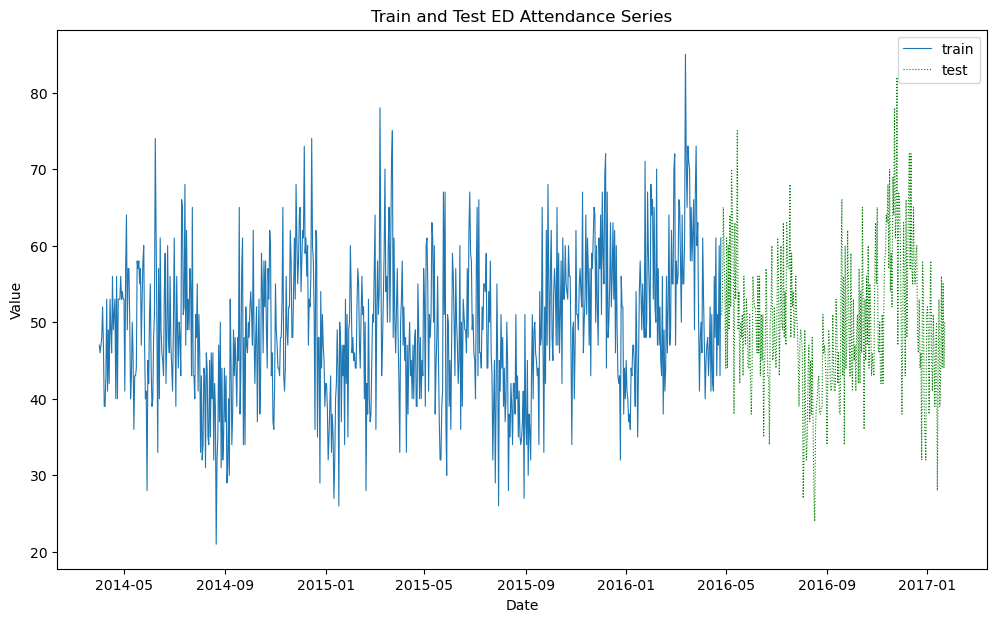

In [13]:
plt.figure(figsize=[12,7])
lw=0.8
plt.plot(train_ed.index, train_ed.values, linestyle="solid", label="train", linewidth=lw)
plt.plot(test_ed.index, test_ed.values, color='g', linestyle="dotted", label="test", linewidth=lw)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Train and Test ED Attendance Series")

plt.show()

# 2. Exploratory Analysis and Describing Data <a id='12'></a>

0. [Plotting functions](#2.0)
1. [Exponentially Weighted Mean](#2.1)
2. [Extreme Values and Normality test](#2.2)
3. [Seasonality evaluation and Autocorrelation](#2.3)
4. [Stationarity tests](#2.4)

#### Plotting functions <a id='2.0'></a>

In [14]:
def plot_range_by_time(df, by_weeks=False, by_months=False,
                       figsize=(15, 6), color='skyblue',
                       plot_mean=True, mean_color='blue',
                       mean_alpha=0.8, mean_linewidth=0.9):
    """
    Plot the range for each day, week, or month of the year,
        shading the area from min to max.


    Parameters:
    - df: DataFrame
        Time series data with a datetime index.
    - by_weeks: bool, optional (default=False)
        If True, plot by weeks.
    - by_months: bool, optional (default=False)
        If True, plot by months.
    - figsize: tuple, optional (default=(15, 6))
        Size of the figure for plotting.
    - color: str, optional (default='skyblue')
        Color for filling the range area.
    - plot_mean: bool, optional (default=True)
        If True, plot the mean line.
    - mean_color: str, optional (default='blue')
        Color for the mean line.
    - mean_alpha: float, optional (default=0.8)
        Alpha value for the mean line.
    - mean_linewidth: float, optional (default=0.9)
        Linewidth for the mean line.
    """
    # Original time series
    original_series = df['paed_ed_attends']

    if by_weeks:
        # Extract week of the year
        time_key = original_series.index.isocalendar().week
        xlabel = 'Week of the Year'
    elif by_months:
        # Extract month of the year
        time_key = original_series.index.month
        xlabel = 'Month of the Year'
    else:
        # Extract month and day
        time_key = original_series.index.to_series().dt.strftime('%m-%d')
        xlabel = 'Date'

    # Calculate range (max - min)
    min_range = original_series.groupby(time_key).min()
    max_range = original_series.groupby(time_key).max()
    mean_of_range = original_series.groupby(time_key).mean()

    # Plotting
    plt.figure(figsize=figsize)
    index = (np.arange(1, 13) if by_months
             else np.arange(1, max(time_key) + 1) if by_weeks
             else min_range.index)
    
    plt.fill_between(index, min_range, max_range, color=color,
                     label='Range')

    if plot_mean:
        plt.plot(index, mean_of_range, color=mean_color,
                 alpha=mean_alpha, linewidth=mean_linewidth,
                 label='Mean')

    title = ('Weekly' if by_weeks
             else 'Monthly' if by_months
             else 'Daily')
    plt.title(f'Range of Time Series Data by {title}')
    plt.xlabel(xlabel)
    plt.ylabel('Range')
    
    plt.legend()

    # Customize x-axis ticks
    if not by_weeks and not by_months:
        
        locator = MonthLocator()
        plt.gca().xaxis.set_major_locator(locator)
        plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))
        plt.xticks(rotation=45, ha='right')
        
    elif by_weeks:
        # For weekly plotting, use the actual week numbers as x-axis ticks
        plt.xticks(np.arange(1, max(time_key) + 1), rotation=0, ha='right')
    else:
        # plt.xticks(np.arange(1, 13),
        #            [(month.strftime('%b')
        #              for month
        #              in pd.to_datetime(range(1, 13, 1), format='%m')
        #             )
        #            ],
        #            rotation=45, ha='right')
        # Adjust xticks for the combined case
        plt.xticks(np.arange(1, 13),
                   ([month.strftime('%b')
                     for month
                     in pd.to_datetime(range(1, 13, 1),
                                       format='%m')
                    ]),
                   rotation=45, ha='right')


    plt.show()

#### Exponentially Weighted Mean <a id='2.1'></a>

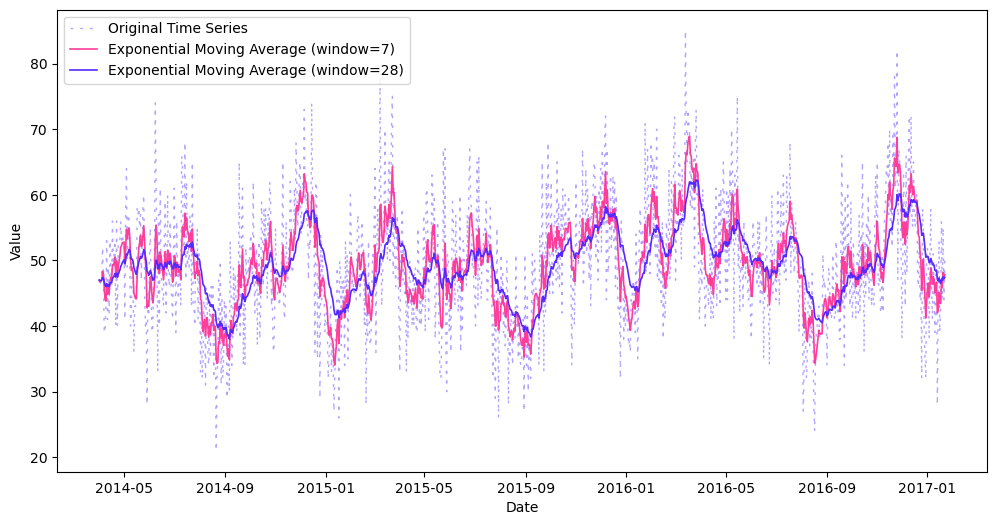

In [15]:
figsize = (12,6)
window_size_1 = 7
window_size_2 = 28
# Original time series
original_series = ed_data['paed_ed_attends']

# Smoothing using rolling mean
rolling_mean = original_series.rolling(window=window_size_1).mean()

# Exponentially Weighted Moving Average 
ema = original_series.ewm(span=window_size_1, adjust=False).mean()
ema_month = original_series.ewm(span=window_size_2, adjust=False).mean()

# Plotting
plt.figure(figsize=figsize)
plt.plot(original_series, label='Original Time Series', color='#937aff', linewidth = 1, alpha=0.7, linestyle=(0,(2,5)))
plt.plot(ema, label=f'Exponential Moving Average (window={window_size_1})',linewidth = 1.2, color='#ff3d9a')
plt.plot(ema_month, label=f'Exponential Moving Average (window={window_size_2})',linewidth = 1.2, color='#5629ff')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

plt.show()

#### Extreme Values and Normality tests <a id='2.2'></a>

In [16]:
# Assessing normality


# Extract the time series data
time_series_data = ed_data['paed_ed_attends']

# Perform Shapiro-Wilk test
statistic, p_value = shapiro(time_series_data)

# Print the normality test results
print("Shapiro-Wilk Test Results:")
print(f"Test Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Result: The data does not follow a normal distribution (reject the null hypothesis)")
else:
    print("Result: The data follows a normal distribution (fail to reject the null hypothesis)")

Shapiro-Wilk Test Results:
Test Statistic: 1.00
P-value: 0.0022
Result: The data does not follow a normal distribution (reject the null hypothesis)


Skewness: 0.23


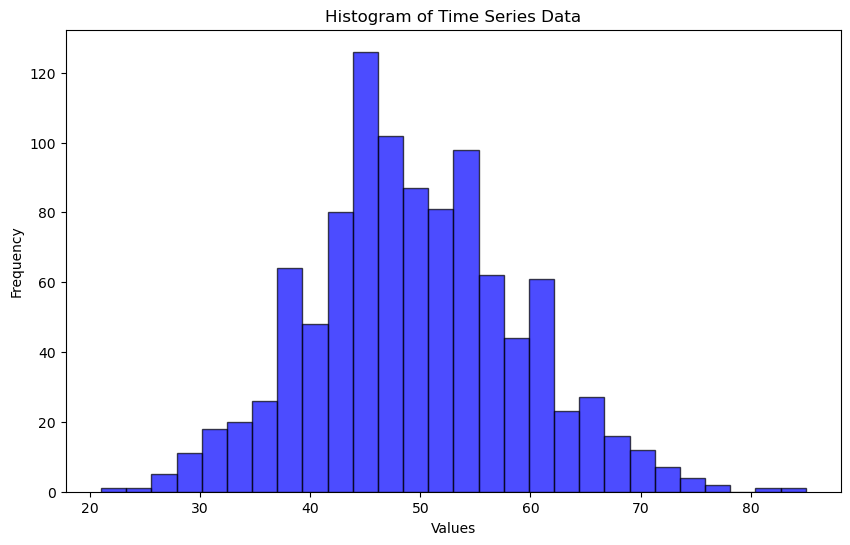

In [17]:
# Calculate skewness
skewness = skew(time_series_data)

# Print the skewness value
print(f"Skewness: {skewness:.2f}")

# Visualize the distribution (optional)
plt.figure(figsize=(10, 6))
plt.hist(time_series_data, bins=28, color='blue',
         edgecolor='black', alpha=0.7)
plt.title('Histogram of Time Series Data')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [18]:
std = ed_data.paed_ed_attends.std()
mean = ed_data.paed_ed_attends.mean()

# Identifying 0.5% of highest rates using Z-score of 2.58
ed_data.loc[ed_data['paed_ed_attends']>(mean+std*2.58)]


paed_ed_attends
date                       
2014-06-08               74
2014-12-15               74
2015-03-08               78
2015-03-23               75
2016-03-13               85
2016-05-15               75
2016-11-22               78
2016-11-25               82

In [19]:
# Identifying 0.5% of lowest rates
ed_data.loc[ed_data['paed_ed_attends']<(mean-std*2.575)]

paed_ed_attends
date                       
2014-08-21               21
2016-08-17               24

#### Seasonality evaluation and Autocorrelation <a id='2.3'></a>

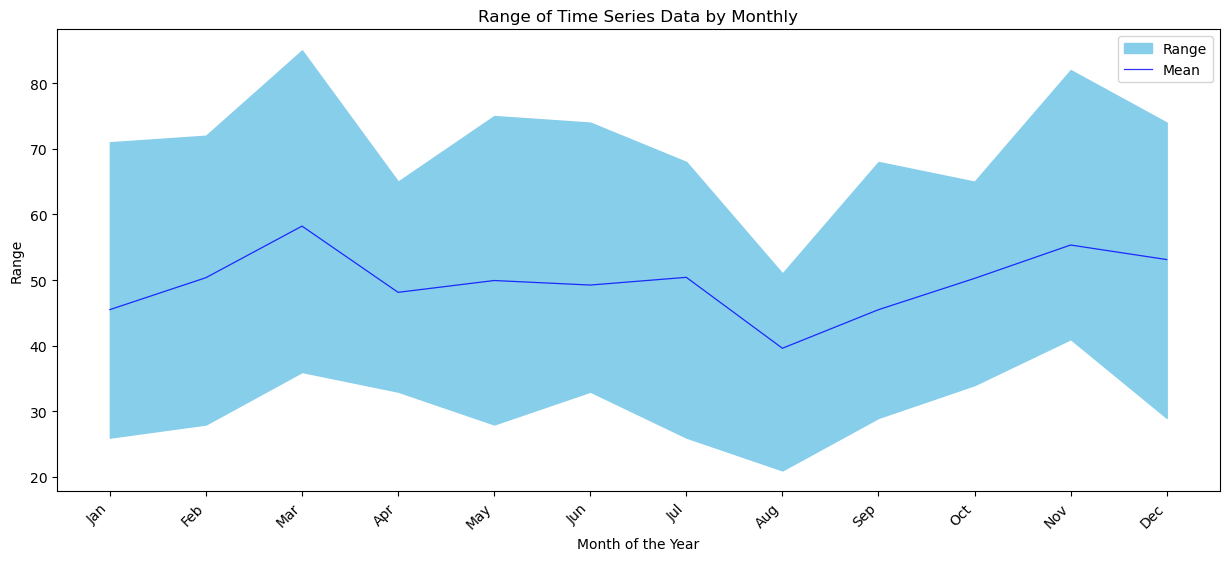

In [20]:
plot_range_by_time(ed_data, by_months=True)

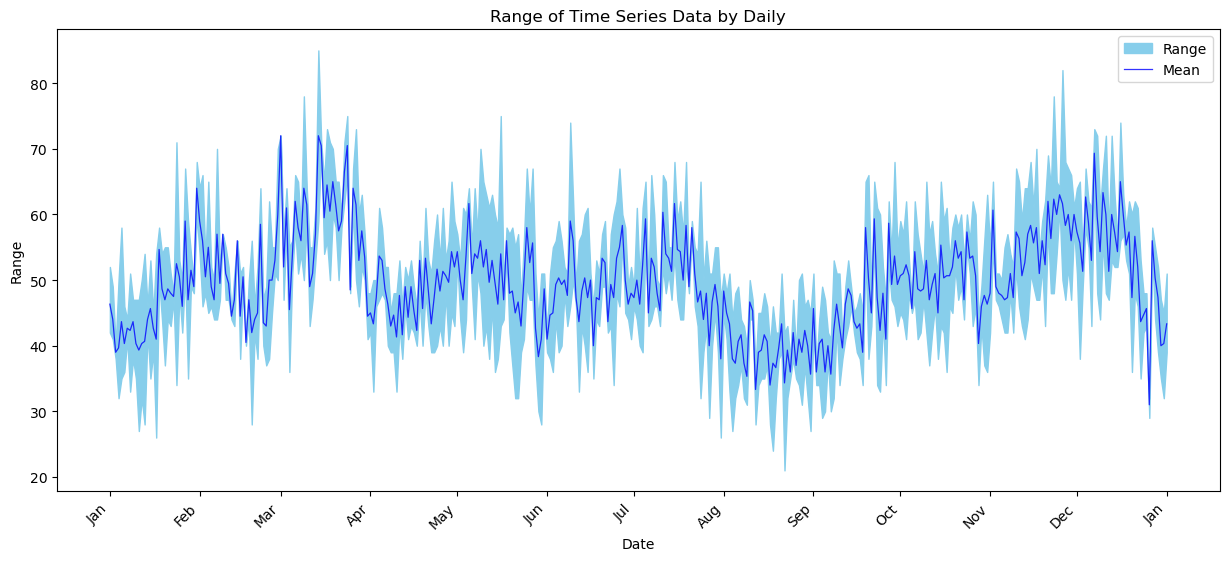

In [21]:
plot_range_by_time(ed_data)

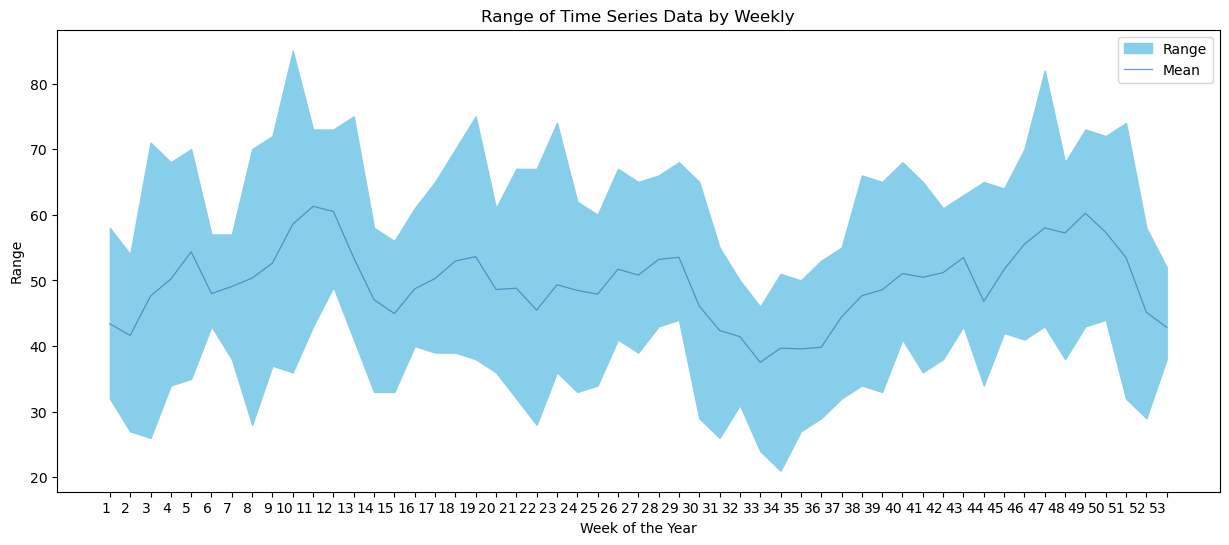

In [22]:
plot_range_by_time(ed_data, by_weeks=True, mean_color='steelblue')

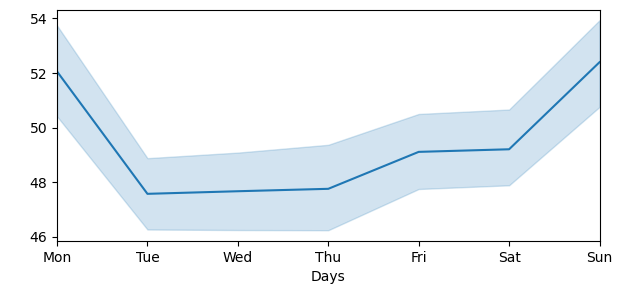

In [23]:
fig, ax = plt.subplots(1,1,figsize=(7,3))
sns.lineplot(x = ed_data.index.isocalendar().day,
             y = ed_data.paed_ed_attends,
            ax=ax)
ax.set_xlabel('Days')
ax.set_ylabel(' ')
ax.set_xlim(1,7)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', "Sat", 'Sun']
ax.set_xticklabels(labels = days);

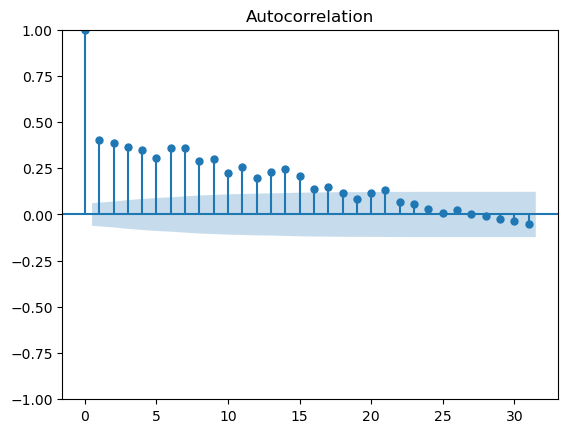

In [24]:
plot_acf(ed_data);

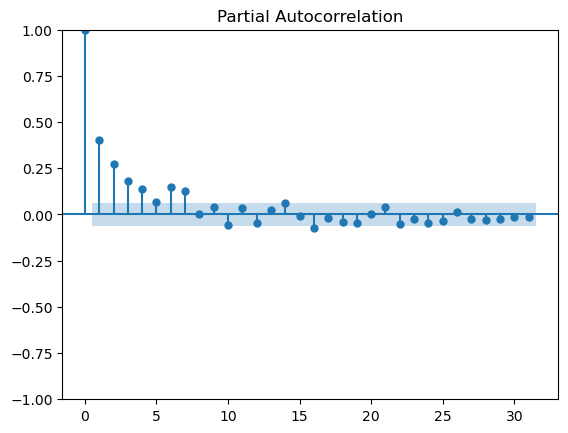

In [25]:
plot_pacf(ed_data, method='ywm');

#### KPSS Stationarity Tests <a id='2.4'></a>


In [26]:
# Perform KPSS test
result = kpss(ed_data, regression='c')

# Extract test statistics and p-value
test_statistic = result[0]
p_value = result[1]
critical_values = result[3]

# Print the results neatly
print("KPSS Test Results (constant):")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

KPSS Test Results (constant):
Test Statistic: 0.3303059468655558
P-value: 0.1
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


In [27]:
result = kpss(ed_data, regression='ct')

# Extract test statistics and p-value
test_statistic = result[0]
p_value = result[1]
critical_values = result[3]

# Print the results neatly
print("KPSS Test Results (trend):")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

KPSS Test Results (trend):
Test Statistic: 0.0670185860193769
P-value: 0.1
Critical Values:
  10%: 0.119
  5%: 0.146
  2.5%: 0.176
  1%: 0.216


##### KPSS tests on training data

In [28]:
# Training Data only
result = kpss(train_ed, regression='c')

# Extract test statistics and p-value
test_statistic = result[0]
p_value = result[1]
critical_values = result[3]

# Print the results neatly
print("KPSS Test Results (constant):")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

KPSS Test Results (constant):
Test Statistic: 0.47805627988201693
P-value: 0.04660894597251872
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739


In [29]:
result = kpss(train_ed, regression='ct', )

# Extract test statistics and p-value
test_statistic = result[0]
p_value = result[1]
critical_values = result[3]

# Print the results neatly
print("KPSS Test Results (trend):")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

KPSS Test Results (trend):
Test Statistic: 0.1128414167771325
P-value: 0.1
Critical Values:
  10%: 0.119
  5%: 0.146
  2.5%: 0.176
  1%: 0.216


# 3. Benchmark model and Utility functions  <a id='13'></a>

0. [Utility functions used throughout](#3.0)
1. [Setting global constants, selecting best naïve](#3.1)

### 3.0 Utility functions used throughout <a id='3.0'></a>

In [30]:
def preds_to_dataframe(y_train, preds, interval_inner,
                       interval_outer, y_test = None):
    '''
    pdmarima.ARIMA models return point forecasts and prediction intervals
    as numpy arrays.  This function converts them into data frames with a
    DateTimeIndex.
    
    Parameters:
    ---------
    y_train: pd.DataFrame or pd.Series
        Training data
        
    preds: np.array
        point forecasts
        
    intervals: np.array
        matrix - prediction intervals
        
    Returns:
    -------
        pd.DataFrame['mean'], pd.DataFrame['lower'. 'upper']
        
    '''
    pred_idx = pd.date_range(start=y_train.index[-1], periods=len(preds)+1, 
                             freq=y_train.index.freq)[1:]
    
    preds = pd.DataFrame(preds, index=pred_idx)
    preds.columns = ['y_pred']
    
    if interval_inner is not None:
        int_alpha = 0.2
        intervals_inner = pd.DataFrame(interval_inner, index=pred_idx)
        intervals_inner.columns = [f'lower_{str(int_alpha).strip("0").strip(".")}',
                             f'upper_{str(int_alpha).strip("0").strip(".")}']
        
    if interval_outer is not None:
        int_alpha = 0.05
        intervals_outer = pd.DataFrame(interval_outer, index=pred_idx)
        intervals_outer.columns = [f'lower_{str(int_alpha).strip("0").strip(".")}',
                                   f'upper_{str(int_alpha).strip("0").strip(".")}']

    pred_intervals = pd.concat([preds,intervals_inner, intervals_outer], axis=1)

    if y_test is not None:
        ground_truth = pd.DataFrame(y_test, index=pred_idx)
        ground_truth.columns = ['y_true']
        pred_intervals = pd.concat([ground_truth, pred_intervals], axis=1)
    
    
    
        
    # if intervals is not None:
    #     print("Default intervals detected")
    #     int_alpha = int_alpha
    #     intervals = pd.DataFrame(intervals, index=pred_idx)
    #     intervals.columns = [f'lower_{str(int_alpha).strip("0").strip(".")}',
    #                          f'upper_{str(int_alpha).strip("0").strip(".")}']
    
    return pred_intervals

In [31]:
def calculate_winklers_score(df, int_alpha):
    """
    Calculate Winkler's Score for prediction intervals.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame containing columns for true values, lower bounds, and upper bounds.

    int_alpha: float
        Significance level for prediction intervals (0.2 for 80%, 0.05 for 95%).

    Returns:
    --------
    winklers_score: float
        Winkler's Score for the given DataFrame and significance level.
    """ 
    
    if int_alpha ==0.2:
        lower = 'lower_2'
        upper = 'upper_2' 
    elif int_alpha==0.05:
        lower= 'lower_05'
        upper = 'upper_05'
    else:
        raise ValueError("Unsupported significance level."
                         + "Please use 0.2 for 80% or 0.05 for 95%.")
        
    
    baseline = sum([(upper_bound-lower_bound)
                    for lower_bound, upper_bound
                    in zip(df[lower], df[upper])
                   ]
                  )
    
    
    underpred = sum([((2/int_alpha)*(lower_bound-y_true))
                     for y_true, lower_bound, upper_bound 
                     in zip( df['y_true'], df[lower], df[upper])
                     if y_true < lower_bound
                    ]
                   )


    overpred = sum([((2/int_alpha)*(y_true-upper_bound))
                    for y_true, lower_bound, upper_bound
                    in zip(df['y_true'], df[lower], df[upper])
                    if y_true > upper_bound
                   ]
                  )
    winklers_score = round(sum([baseline, underpred, overpred])
                           / len(df),
                           3
                          )

    return winklers_score

In [32]:
def plot_predictions_intervals(df, training_df, y_true='y_true', y_pred='y_pred',
                               upper_2='upper_2', lower_2='lower_2',
                               upper_05='upper_05', lower_05='lower_05',
                               train_col='paed_ed_attends', linewidth=1.5,
                               markersize=5, linestyle='-', figsize = (10,6),
                               title=None, colors=None):
    """
    Plot predictions, confidence intervals, and training dataset on the same plot.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame containing columns for true values, predictions, lower bounds, and upper bounds.

    training_df: pd.DataFrame
        DataFrame containing the training dataset.

    y_true, y_pred, upper_2, lower_2, upper_05, lower_05, train_col: str, optional
        Column names for respective data (default values correspond to the provided column names).

    linewidth: float, optional
        Line width for the plot (default is 2).

    markersize: float, optional
        Marker size for the plot (default is 8).

    linestyle: str, optional
        Line style for the plot (default is '-').

    colors: dict, optional
        Dictionary containing color names for different elements. 
        Example: {'training': 'slateblue', 'true_values': 'orchid', 'predictions': 'coral',
                  '80_interval': 'sandybrown', '95_interval': 'bisque'}.
        If not provided, default colors will be used.

    Returns:
    --------
    None (displays the plot).
    """
    # Extract relevant columns from the DataFrames
    dates = df.index
    y_true = df[y_true]
    y_pred = df[y_pred]
    lower_2 = df[lower_2]
    upper_2 = df[upper_2]
    lower_05 = df[lower_05]
    upper_05 = df[upper_05]

    training_dates = training_df.index
    training_values = training_df[train_col]
    
    if title is None:
        title = 'Predictions, Prediction Intervals, and Training Dat'

    # Plotting
    plt.figure(figsize=figsize)

    # Set default colors if not provided
    if colors is None:
        colors = {'training': 'slateblue', 'true_values': 'orchid', 'predictions': 'coral',
                  '80_interval': 'sandybrown', '95_interval': 'bisque'}

    # Plot training dataset
    plt.plot(training_dates, training_values, label='Training Dataset', linestyle=linestyle,
             color=colors['training'], linewidth=linewidth, markersize=markersize)

    # Plot true values and predictions
    plt.plot(dates, y_true, label='True Values', marker='o', linestyle=linestyle,
             color=colors['true_values'], linewidth=linewidth, markersize=markersize)
    plt.plot(dates, y_pred, label='Predictions', marker='x', linestyle=linestyle,
             color=colors['predictions'], linewidth=linewidth, markersize=markersize)

    # Plot 80% prediction intervals
    plt.fill_between(dates, lower_2, upper_2, color=colors['80_interval'], alpha=0.5, label='80% Prediction Interval')

    # Plot 95% prediction intervals
    plt.fill_between(dates, lower_05, upper_05, color=colors['95_interval'], alpha=0.5, label='95% Prediction Interval')

    # Customize the plot
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend(loc='upper center')
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [33]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    data - arraylike - the training data
    preds - numpy.array, vector of predictions 
    
    Returns:
    -------
    pandas.DataFrame
    '''
    
    start = pd.date_range(start=data.index.max(), periods=2, 
    freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    
    return pd.DataFrame(preds, index=idx)

In [34]:
def evaluate_prediction(df,name, true_col='y_true', pred_col='y_pred', 
                        lower_col_80='lower_2', upper_col_80='upper_2',
                        lower_col_95='lower_05', upper_col_95='upper_05',
                        y_pred_col = 'y_pred'):
    """
    Evaluate predictions by calculating prediction interval coverage and Winkler's Score for both 80% and 95% intervals.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame containing columns for true values, predictions, lower bounds, and upper bounds.

    true_col: str, optional
        Column name for true values (default is 'y_true').

    pred_col: str, optional
        Column name for predictions (default is 'y_pred').

    lower_col_80: str, optional
        Column name for lower bounds of 80% confidence interval (default is 'lower_2').

    upper_col_80: str, optional
        Column name for upper bounds of 80% confidence interval (default is 'upper_2').

    lower_col_95: str, optional
        Column name for lower bounds of 95% confidence interval (default is 'lower_05').

    upper_col_95: str, optional
        Column name for upper bounds of 95% confidence interval (default is 'upper_05').

    weight: float, optional
        Weight parameter for Winkler's Score (default is 0.5).

    Returns:
    --------
    result_df: pd.DataFrame
        DataFrame with columns for 80% and 95% coverage and Winkler's Score.
    """
    # Calculate prediction interval coverage
    if df is not None:
        y_true = df[true_col]
        y_pred = df[y_pred_col]
        lower_80 = df[lower_col_80]
        upper_80 = df[upper_col_80]
        lower_95 = df[lower_col_95]
        upper_95 = df[upper_col_95]
    elif df is None:
        y_true = np.asarray(true_col, dtype=float)
        y_pred = np.asarray(pred_col, dtype='float64')


        
    if ((lower_col_80 is not None)
        and (lower_col_95 is not None)):

        coverage_80 = ((y_true >= lower_80) & (y_true <= upper_80)).mean()
        coverage_95 = ((y_true >= lower_95) & (y_true <= upper_95)).mean()

        # Calculate Winkler's Scores
        winklers_score_80 = calculate_winklers_score(df, int_alpha=0.2)
        winklers_score_95 = calculate_winklers_score(df, int_alpha=0.05)
        

        
    elif ((lower_col_80 is None)
        and (lower_col_95 is None)):
        coverage_80 = np.nan
        coverage_95 = np.nan
        winklers_score_80 = np.nan
        winklers_score_95 = np.nan
    #     mean_absolute_error = np.mean(np.abs(y_true - y_pred))
    #     mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    #MAE 
    mean_abs_error = mean_absolute_error(y_true, y_pred)
    #MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    #RMSE
    rmse = root_mean_squared_error(y_true, y_pred)
    
    # Create a DataFrame with the results
    result_df = pd.DataFrame({
        'MAE': [mean_abs_error],
        'MAPE': [mape],
        'RMSE':[rmse],
        'Coverage_80': [coverage_80],
        'Coverage_95': [coverage_95],
        'Winkler_Score_80': [winklers_score_80],
        'Winkler_Score_95': [winklers_score_95]
    })
    
    result_df.index = [name]

    return result_df

In [35]:
def rolling_forecast_origin(train, test, horizon=28, spacer=14):
    '''
    Generate rolling forecast origin splits for time series data.

    Parameters:
    - train : numpy.ndarray or pd.DataFrame
        Training data.
    - test : numpy.ndarray or pd.DataFrame
        Test data.
    - horizon : int, optional (default=28)
        Forecast horizon, i.e., the number of time points to predict into the future.
    - spacer : int, optional (default=14)
        Spacer between consecutive training sets.

    Yields:
    tuple
        A tuple containing the training set and the corresponding test set for each iteration.

    Example:
    >>> train_data = np.arange(1, 10)
    >>> test_data = np.arange(10, 18)
    >>> for train_split, test_split
    ...    in rolling_forecast_origin(train_data,
    ...                               test_data,
    ...                               horizon=3,
    ...                               spacer=1):
    ...     print(f'Train: {train_split}, Test: {test_split}')
    ...
    Train: [1 2 3 4 5 6 7 8 9], Test: [10 11 12]
    Train: [1 2 3 4 5 6 7 8 9 10 11 12 13 14], Test: Test: [15 16 17]

    '''
    min_train_size = len(train)
    
    # This allows to handle both numpy.ndarray (useful for testing)
    if (isinstance(train, np.ndarray)
        and isinstance(test, np.ndarray)):
        all_data = np.concatenate((train, test))
        
    elif (isinstance(train, pd.core.frame.DataFrame)
          and isinstance(test, pd.core.frame.DataFrame)):
        all_data = pd.concat([train, test])
    else:
        raise ValueError("Input types for 'train' and 'test' must be either numpy.ndarray or pd.DataFrame.")
    
    for i in range(int(len(test) / (spacer + horizon)) + 1):
        split_index = min_train_size + i * horizon + spacer * i
        split_train = all_data[:split_index]
        split_test = all_data[split_index: split_index + horizon]

        if len(split_test) == horizon:
            yield split_train, split_test
        else:
            break


In [36]:
def cross_val_test(model, cv_generator, horizon=28, pi_alpha_inner = 0.2, pi_alpha_outer = 0.05):
    """
    Perform cross-validation for time series forecasting models.

    Parameters:
    -----------
    model : object
        Time series forecasting model object with a 'fit' method.

    cv_generator : iterable
        Time series cross-validation generator yielding
        training and test sets for each iteration.
        See rolling_forecast_origin().

    horizon : int, optional
        Forecast horizon for the model (default is 28).

    pi_alpha_inner : float, optional
        Significance level for the inner prediction interval (default is 0.2).

    pi_alpha_outer : float, optional
        Significance level for the outer prediction interval (default is 0.05).

    Returns:
    --------
    pd.DataFrame
        DataFrame containing evaluation metrics for each cross-validation fold.
    """
    overall_eval = pd.DataFrame()

    # Generate rolling forecast origin splits for each iteration
    for i, (train, test) in enumerate(cv_generator):
        model.fit(train)

        # Generate predictions and prediction intervals based on the model type
        if isinstance(model, Average):
            
            # Making predictions twice to output both 80% and 95% PI coverage
            # While AutoNaive does accept return_predict_int as a list,
            # Other models do not. 
            preds, (interval_inner,
                    interval_outer) = model.predict(horizon=horizon,
                                                    return_predict_int=True,
                                                    alpha=[pi_alpha_inner,
                                                           pi_alpha_outer]
                                                   )


        elif isinstance(model, ARIMA):
            preds, interval_inner = model.predict(horizon=horizon, return_conf_int=True, alpha=pi_alpha_inner)
            preds, interval_outer = model.predict(horizon=horizon, return_conf_int=True, alpha=pi_alpha_outer)
            interval_inner = preds_as_series(train, interval_inner)
            interval_outer = preds_as_series(train, interval_outer)

        # Convert predictions to DataFrame and evaluate
        pred_df = preds_to_dataframe(train, preds, interval_inner=interval_inner, interval_outer=interval_outer, y_test=test)
        eval_fold = evaluate_prediction(pred_df, name=f'{str(model)}_{i}')

        # Concatenate evaluation metrics for each fold
        overall_eval = pd.concat([overall_eval, eval_fold], axis=0)

    return overall_eval

In [37]:
def add_metric_averages(df):
    """
    Add row-wise averages for each metric to the DataFrame.

    Parameters:
    -----------
    df: pd.DataFrame
        DataFrame containing metric values.

    Returns:
    --------
    pd.DataFrame
        DataFrame with additional rows containing averages for each metric.
    """
    # Calculate row-wise averages for each metric
    metric_averages = df.mean(axis=0)

    # Create a DataFrame with the averages and set appropriate names
    averages_df = pd.DataFrame(metric_averages).T
    averages_df.index = [df.index[0][:-2]+'_avg']

    # Concatenate the original DataFrame with the new row-wise averages
    df_with_averages = pd.concat([df, averages_df]).round(decimals=3)

    return df_with_averages

#### 3.1.1 Testing Rolling Origin TS-cross-validation function <a id="tscv"></a>

In [38]:
def plot_splits_lengths(generator, horizon=4, spacer=2):
    train_lengths = []
    test_lengths = []

    for i, (split_train, split_test) in enumerate(generator):
        train_length = len(split_train)
        test_length =  len(split_test)
        train_lengths.append(train_length)
        test_lengths.append(test_length)

    plt.figure(figsize=(10, 5))
    y_inc = 5.1
    # Plot each interval length as a horizontal line
    for i, (train, test) in enumerate(zip(train_lengths, test_lengths)):
        plt.hlines(y=i, xmin=0, xmax=train, color='slateblue', label=f'Fold {i+1}', linewidth=2)
        plt.hlines(y=i, xmin=(train), xmax=(train+test), color='red', label=f'Fold {i+1}', linewidth=2)
        plt.vlines(x=train+test+spacer, ymax=i, ymin=i+y_inc, alpha = 0.7)
        y_inc -=1

    plt.title('Lengths of Folds - Train and Test')
    plt.xlabel('Fold Length')
    plt.yticks(range(len(train_lengths)), [f'Fold {i+1}' for i in range(len(train_lengths))])
    plt.show()

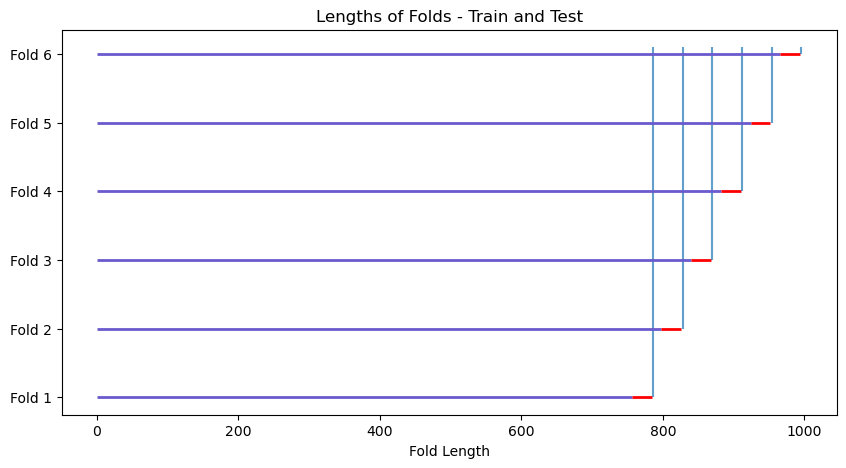

In [39]:
# This is just to make sure the fold lengths and spacer are as intended
cross_val_gen = rolling_forecast_origin(train_ed, test_ed,
                                        horizon=28, spacer=14)
plot_splits_lengths(cross_val_gen)

### 3.1 Setting global constants, selecting best Naive model <a id='3.1'></a>

In [40]:
HORIZON = 28
MIN_TRAIN_SIZE = len(train_ed)//3
STEP = 28

In [41]:
metric_list = ['mase', 'mae', 'mape', 'smape', 'mse', 'rmse', 'me']
naive_metrics = {}

# Loop through metrics to ensure that they produce conconrdant Naive models
for metric in metric_list:
    model_naive_metric = auto_naive(y_train = train_ed,
                                    horizon=HORIZON,
                                    seasonal_period=7,
                                    metric=metric, step=STEP)
    
    if isinstance(model_naive_metric['model'], Average):
        naive_metrics.update(model_naive_metric)
    else:
        print("Different Naive model than Average")
        suffix = 1
        to_update = {f'model_{suffix}':model_naive_metric['model'],
                    f'metric_{suffix}':metric,
                    f'{metric}':model_naive_metric[metric]}
        naive_metrics.update(to_update)
        suffix+=1

Different Naive model than Average


In [42]:
naive_metrics
# Reviewing this reveals that only 'mean error' gives
    # a different model (Drift()); which we can ignore

{'model': Average(),
 'mase': 0.7473366495152516,
 'mae': 7.798080358423279,
 'mape': 16.25210710650625,
 'smape': 15.864153420318619,
 'mse': 97.27994737526525,
 'rmse': 9.64129377271162,
 'model_1': Drift(),
 'metric_1': 'me',
 'me': -4.38817425604175}

In [43]:
avg = Average()
avg.fit(train_ed)
avg_preds, avg_intervals = avg.predict(horizon=HORIZON,
                                       return_predict_int=True,
                                       alpha=[0.2, 0.05])
avg_df = preds_to_dataframe(train_ed, avg_preds,
                            interval_inner=avg_intervals[0],
                            interval_outer=avg_intervals[1],
                            y_test=test_ed)

In [44]:
# Simple evaluation of next month predictions
# This will not be used in selection 
evaluate_prediction(avg_df, name="Average()")

MAE       MAPE       RMSE  Coverage_80  Coverage_95  \
Average()  7.975624  13.794354  10.186919     0.785714     0.928571   

           Winkler_Score_80  Winkler_Score_95  
Average()            36.349            50.497

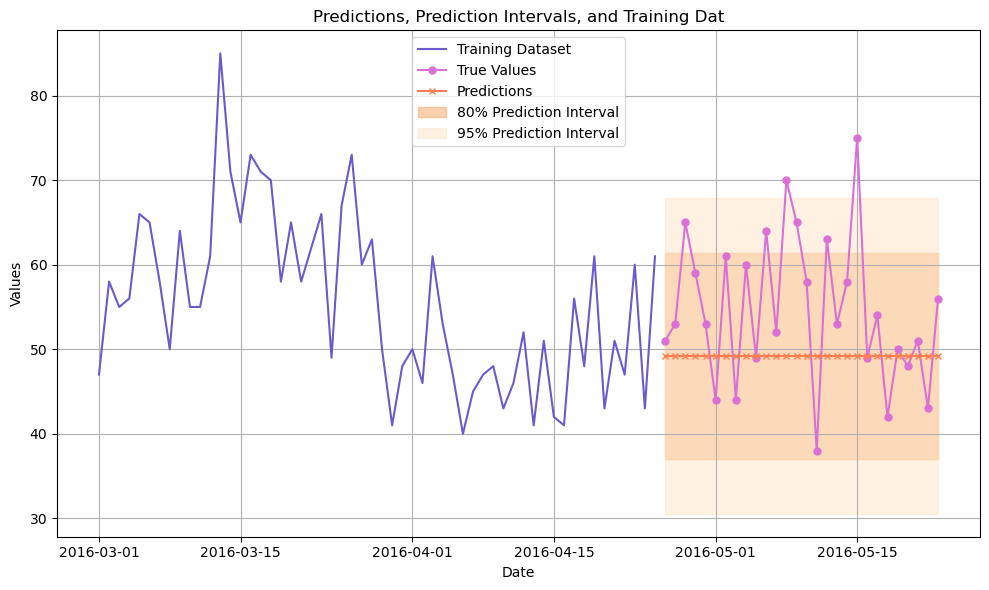

In [45]:
# Plotting Average Predictions for the next month
plot_predictions_intervals(avg_df, train_ed[700:])

In [46]:
# Calculating metrics of Average() through rolling origin cross validation
# First row will be equivalent to the previosuly obrained predictions (displayed above)

generator = rolling_forecast_origin(train_ed, test_ed,
                                    horizon=HORIZON, spacer=14)
avg_cv_eval = cross_val_test(avg, generator)
avg_cv_eval = add_metric_averages(avg_cv_eval)

In [47]:
avg_cv_eval

MAE    MAPE    RMSE  Coverage_80  Coverage_95  \
Average()_0     7.976  13.794  10.187        0.786        0.929   
Average()_1     5.164  11.240   6.491        0.929        1.000   
Average()_2     6.653  17.925   9.053        0.750        0.964   
Average()_3     7.070  16.019   8.302        0.857        1.000   
Average()_4     6.107  12.115   7.409        0.857        1.000   
Average()_5    12.042  18.910  14.418        0.607        0.857   
Average()_avg   7.502  15.001   9.310        0.798        0.958   

               Winkler_Score_80  Winkler_Score_95  
Average()_0              36.349            50.497  
Average()_1              26.266            37.202  
Average()_2              32.981            42.601  
Average()_3              28.330            36.964  
Average()_4              27.889            36.660  
Average()_5              55.693            84.946  
Average()_avg            34.585            48.145

# 4. AutoARIMA & adjusted ARIMA models <a id='14'></a>

0. [ARIMA-Sepcific functions](#4.0)
1. [Selecting AutoARIMA model](#4.1)
2. [Exploring Additional ARIMA models](#4.2)

#### ARIMA Specific functions <a id='4.0'></a>

In [48]:
def evaluate_arimas(model_list, train, test, plot=False, horizon=28, arima_eval=pd.DataFrame(), figsize=(10,6)):
    """
    Evaluate ARIMA models using cross-validation and optional plotting.

    Parameters:
    -----------
    model_list : list
        List of ARIMA model objects to be evaluated.

    train : pd.Series
        Time series training data.

    test : pd.Series
        Time series test data.

    plot : bool, optional
        If True, plot predictions and intervals for each model (default is False).

    horizon : int, optional
        Forecast horizon for the models (default is 28).

    arima_eval : pd.DataFrame, optional
        DataFrame to store evaluation metrics for each model (default is an empty DataFrame).

    Returns:
    --------
    pd.DataFrame
        DataFrame containing evaluation metrics for each ARIMA model.
    """
    for model in model_list:
        model.fit(y=train)

        if plot:
            m_preds, m_int_inner = model.predict(n_periods=horizon,
                                                 return_conf_int=True,
                                                 alpha=0.2)
            _, m_int_outer = model.predict(n_periods=horizon,
                                           return_conf_int=True,
                                           alpha=0.05)

            m_df = preds_to_dataframe(train, m_preds,
                                      interval_inner=m_int_inner,
                                      interval_outer=m_int_outer,
                                      y_test=test)

            plot_predictions_intervals(m_df, train[-28*2:],
                                       figsize=figsize, title=str(model))

        generator = rolling_forecast_origin(train, test)

        model_eval = cross_val_test(model, generator, horizon=horizon)
        model_eval = add_metric_averages(model_eval)

        arima_eval = pd.concat([arima_eval, model_eval.iloc[-1]], axis=1)

    return arima_eval


#### 4.1 Selecting AutoARIMA model <a id='4.1'></a>

In [49]:
aut_arima_model = auto_arima(y=train_ed,seasonal=True, m=7)
aut_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  756
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -2647.923
Date:                                Fri, 16 Feb 2024   AIC                           5303.846
Time:                                        12:55:02   BIC                           5322.353
Sample:                                    04-01-2014   HQIC                          5310.975
                                         - 04-25-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8029      0.022    -36.792      0.000      -0.846      -0.760
ma.S.L7        0.0737      0.036      2.027      0.043       0.002       0.145
ma.S.L14       0.0977      0.036      2.726      0.006       0.027       0.168
sigma2        65.0360      3.319     19.594      0.000      58.530      71.542
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.90   Prob(JB):                         0.50
Heteroskedasticity (H):               1.06   Skew:                             0.10
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
aut_ar_m = ARIMA(order=(0, 1, 1), seasonal_order=(0, 0, 2, 7),m=7, with_intercept=False)
# Fitting and nsuring that the defined model is indentical to on suggested by AutoARIMA
aut_ar_m.fit(y=train_ed).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  756
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -2647.923
Date:                                Fri, 16 Feb 2024   AIC                           5303.846
Time:                                        12:55:02   BIC                           5322.353
Sample:                                    04-01-2014   HQIC                          5310.975
                                         - 04-25-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8029      0.022    -36.792      0.000      -0.846      -0.760
ma.S.L7        0.0737      0.036      2.027      0.043       0.002       0.145
ma.S.L14       0.0977      0.036      2.726      0.006       0.027       0.168
sigma2        65.0360      3.319     19.594      0.000      58.530      71.542
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.90   Prob(JB):                         0.50
Heteroskedasticity (H):               1.06   Skew:                             0.10
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
# Running the model twice to get confidence intervals for plotting the next month
aut_ar_preds, aut_ar_int_inner = aut_ar_m.predict(n_periods=HORIZON,
                                                  return_conf_int=True,
                                                  alpha=0.2)
_, aut_ar_int_outer= aut_ar_m.predict(n_periods=HORIZON,
                                      return_conf_int=True,
                                      alpha=0.05)

aut_ar_df = preds_to_dataframe(train_ed, aut_ar_preds,
                               interval_inner=aut_ar_int_inner,
                               interval_outer=aut_ar_int_outer,
                               y_test=test_ed)

In [52]:
# Evaluating next month predicitons
arima_results_df = evaluate_prediction(aut_ar_df, name="AutoARIMA")
print(arima_results_df)

                MAE       MAPE      RMSE  Coverage_80  Coverage_95  \
AutoARIMA  7.193158  13.098482  9.005808     0.857143     0.964286   

           Winkler_Score_80  Winkler_Score_95  
AutoARIMA            32.099            40.723  


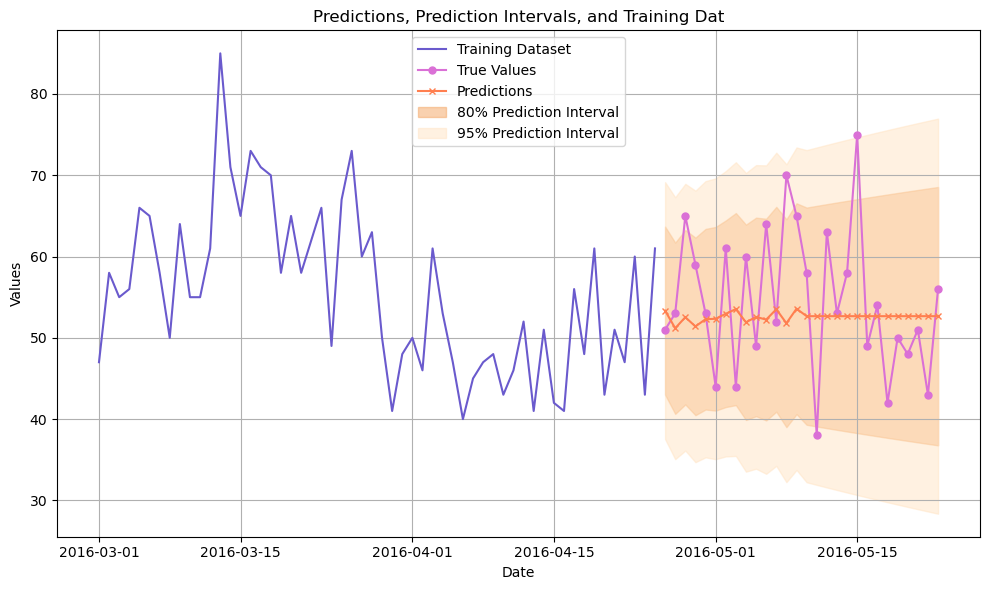

In [53]:
# Plotting the results of next month prediction
plot_predictions_intervals(aut_ar_df, training_df=train_ed[700:])

In [54]:
# Evaluating the AutoARIMA via Cross-validation
generator = rolling_forecast_origin(train_ed, test_ed)

# Auto ARIMA 
aut_arima_eval = cross_val_test(aut_ar_m, generator)
aut_arima_eval = add_metric_averages(aut_arima_eval)

In [55]:
aut_arima_eval

MAE    MAPE    RMSE  Coverage_80  \
 ARIMA(0,1,1)(0,0,2)[7]          _0    6.252  11.601   7.251         0.90   
 ARIMA(0,1,1)(0,0,2)[7]          _1    4.836  11.054   6.193         0.90   
 ARIMA(0,1,1)(0,0,2)[7]          _2    7.468  15.184   8.244         0.90   
 ARIMA(0,1,1)(0,0,2)[7]          _3    3.456   8.097   4.399         1.00   
 ARIMA(0,1,1)(0,0,2)[7]          _4    5.845  11.919   7.400         0.80   
 ARIMA(0,1,1)(0,0,2)[7]          _5    9.970  18.076  12.879         0.60   
 ARIMA(0,1,1)(0,0,2)[7]          _avg  6.304  12.655   7.728         0.85   

                                       Coverage_95  Winkler_Score_80  \
 ARIMA(0,1,1)(0,0,2)[7]          _0           1.00            24.221   
 ARIMA(0,1,1)(0,0,2)[7]          _1           1.00            24.680   
 ARIMA(0,1,1)(0,0,2)[7]          _2           1.00            24.226   
 ARIMA(0,1,1)(0,0,2)[7]          _3           1.00            22.246   
 ARIMA(0,1,1)(0,0,2)[7]          _4           1.00            27.539   
 ARIMA(0,1,1)(0,0,2)[7]          _5           0.70            54.224   
 ARIMA(0,1,1)(0,0,2)[7]          _avg         0.95            29.523   

                                       Winkler_Score_95  
 ARIMA(0,1,1)(0,0,2)[7]          _0              34.392  
 ARIMA(0,1,1)(0,0,2)[7]          _1              34.389  
 ARIMA(0,1,1)(0,0,2)[7]          _2              34.078  
 ARIMA(0,1,1)(0,0,2)[7]          _3              34.022  
 ARIMA(0,1,1)(0,0,2)[7]          _4              33.775  
 ARIMA(0,1,1)(0,0,2)[7]          _5              79.038  
 ARIMA(0,1,1)(0,0,2)[7]          _avg            41.616

#### 4.2 Exploring additional ARIMA Models <a id='4.2'></a>

In [56]:
# Trying more ARIMA models:
    # >>> auto_arima(y=train_ed,seasonal=True, stepwise=False, m=7)
    # Returns slightly different results, let's try this model

aut_ar_m2=ARIMA(order=(0, 1, 1), seasonal_order=(2, 0, 0, 7), with_intercept=False)

In [57]:
# Including 7 as P in order to capture autorcorrelatino over the week
model_1 = ARIMA(order=(7, 0, 1), seasonal_order=(0, 1, 1, 7), with_intercept=False)

# Inlcuding all significant autocorrelated days from the KPSS test
model_2 = ARIMA(order=(14, 0, 1), seasonal_order=(0, 1, 1, 7), with_intercept=False)

# Capturing both weekly and yearly seasonality
model_3 = ARIMA(order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))

# Removing constraints of defualt auto_arima parameters  
arima_unhindged = auto_arima(train_ed, max_p = 21, max_d = 5, max_q=28, max_P = 52,max_D = 5, max_Q = 52, m=7 )

In [58]:
model_list = [aut_ar_m, aut_ar_m2, model_1, model_2, model_3, arima_unhindged]

##### Plotting All ARIMA Models <a id="arima_plots"></a>

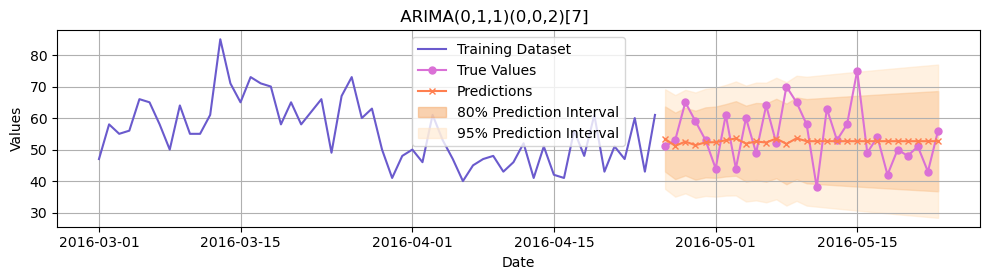

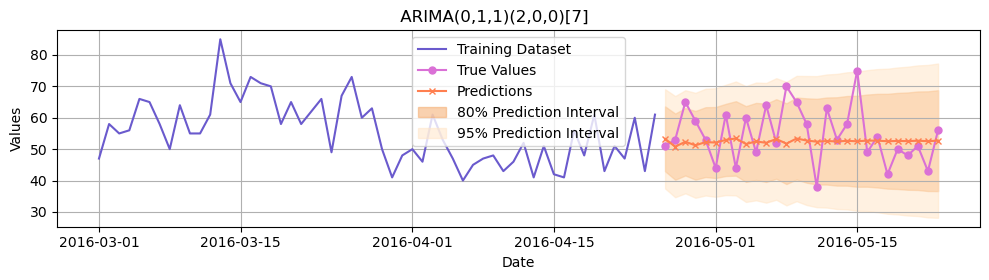

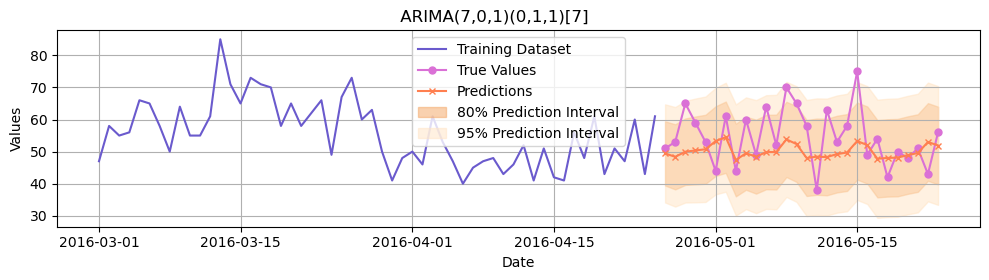

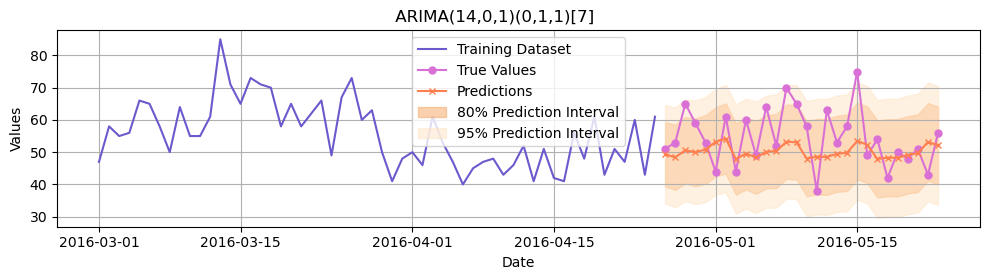

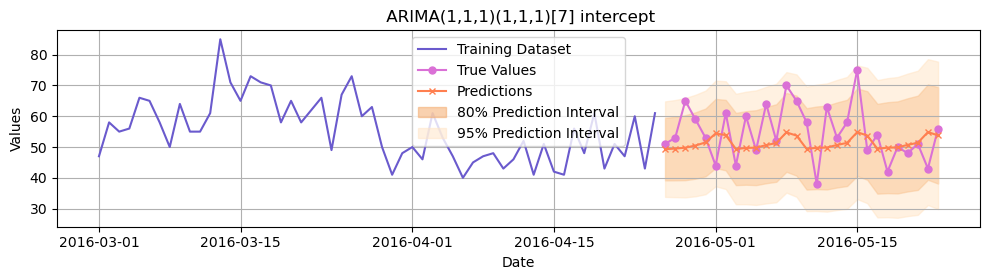

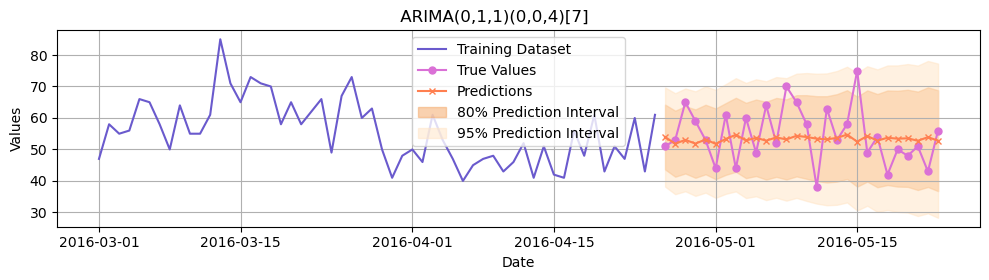

In [59]:
# Plotting and returning cross-validation evaluation of ARIMAs using previously defined function 
evals = evaluate_arimas(model_list, train_ed, test_ed,
                        plot=True, figsize= (10,2.9),
                        arima_eval=avg_cv_eval.iloc[-1]
                       )

In [60]:
evals.T

MAE    MAPE   RMSE  Coverage_80  \
Average()_avg                           7.502  15.001  9.310        0.798   
 ARIMA(0,1,1)(0,0,2)[7]          _avg   6.304  12.655  7.728        0.850   
 ARIMA(0,1,1)(2,0,0)[7]          _avg   6.296  12.627  7.728        0.850   
 ARIMA(7,0,1)(0,1,1)[7]          _avg   6.049  11.753  7.502        0.883   
 ARIMA(14,0,1)(0,1,1)[7]          _avg  6.071  11.827  7.467        0.883   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg   6.332  12.501  7.930        0.850   
 ARIMA(0,1,1)(0,0,4)[7]          _avg   6.228  12.525  7.654        0.850   

                                        Coverage_95  Winkler_Score_80  \
Average()_avg                                 0.958            34.585   
 ARIMA(0,1,1)(0,0,2)[7]          _avg         0.950            29.523   
 ARIMA(0,1,1)(2,0,0)[7]          _avg         0.950            29.541   
 ARIMA(7,0,1)(0,1,1)[7]          _avg         0.950            29.274   
 ARIMA(14,0,1)(0,1,1)[7]          _avg        0.950            28.839   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg         0.933            30.010   
 ARIMA(0,1,1)(0,0,4)[7]          _avg         0.950            29.029   

                                        Winkler_Score_95  
Average()_avg                                     48.145  
 ARIMA(0,1,1)(0,0,2)[7]          _avg             41.616  
 ARIMA(0,1,1)(2,0,0)[7]          _avg             41.632  
 ARIMA(7,0,1)(0,1,1)[7]          _avg             43.309  
 ARIMA(14,0,1)(0,1,1)[7]          _avg            41.896  
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             43.011  
 ARIMA(0,1,1)(0,0,4)[7]          _avg             40.995

# 5. Prophet <a id='15'></a>
0. [Functions for Prophet models & Wrangle Data](#5.0)
1. [Fitting and Evaluating basic Prophet model](#5.1)
2. [Adding UK Holidays to Prophet: plotting and cross validation](#5.2)
3. [Prophet with more rigid trend changepoints](#5.3)
4. [Prophet with Higher Fourier Order for Seasonalities](#5.4)
5. [Adding changepoints based on PHE Flu Surveillence](#5.5)

#### Functions for Prophet models & Wrangle Data <a id='5.0'></a>

In [61]:
def wrangle_timeseries(df, y_col = "paed_ed_attends", index_name = 'date'):
    
    df = df.reset_index()
    df.rename(columns={index_name:"ds", y_col:"y"}, inplace=True)  
    return df

In [62]:
def cv_prophet_model(model, data_all, cutoffs_cv, horizon,
                     pred_int, name='default_Prophet'):
    """
    Perform cross-validation with a Prophet model, calculate metrics,
    and return a DataFrame containing the results.

    Parameters:
    - model (Prophet): The Prophet model instance.
    - data_all (pd.DataFrame): time series data used for training and validation.
    - cutoffs_cv (list): List of cutoff dates for cross-validation.
    - horizon (str): The forecast horizon for evaluation.
    - pred_int (float): Prediction interval.
    - name (str, optional): Name to be used as the index in resulting df.

    Returns:
    - pd.DataFrame: A DataFrame containing performance metrics
        and Winkler's score for the specified prediction interval.
    """

    winklers_dict = {}
    
    alpha = round((1 - pred_int), 2)

    # Fit the model to the entire data
    model.fit(data_all)

    # Perform cross-validation
    cv_df = cross_validation(model, horizon=horizon, cutoffs=cutoffs_cv,
                             disable_tqdm=True)

    # Calculate performance metrics
    performance_df = performance_metrics(cv_df)
    performance_df = performance_df.loc[performance_df.horizon == horizon]
    performance_df.rename({'rmse': 'RMSE', 'mae': 'MAE',
                           'mape': 'MAPE',
                           'coverage': f'Coverage_{int(pred_int * 100)}'},
                          axis=1, inplace=True)

    # Determine column names for bounds based on prediction interval
    lower_col = 'lower_2' if pred_int == 0.8 else 'lower_05'
    upper_col = 'upper_2' if pred_int == 0.8 else 'upper_05'

    # Rename columns in the cross-validation DataFrame
    cv_df = cv_df.rename({"ds": 'date', 'yhat': 'y_pred',
                          'yhat_lower': lower_col,
                          'yhat_upper': upper_col,
                          'y': 'y_true'}, axis=1)

    assert alpha == 0.05 or alpha==0.2
    # Calculate Winkler's score and store it in winklers_dict
    winklers_dict[f'Winkler_Score_{int(pred_int * 100)}'
                 ] = calculate_winklers_score(cv_df, int_alpha=alpha)

    # Add Winkler's score columns to the performance DataFrame
    performance_df = performance_df.assign(**winklers_dict)

    # Remove unwanted columns
    columns_to_remove = ['horizon', 'mse', 'mdape', 'smape']
    performance_df = performance_df.drop(columns=columns_to_remove)
    performance_df['MAPE'] = performance_df['MAPE']*100

    # Set a custom index
    performance_df = performance_df.set_index(pd.Index([name]))

    return performance_df.round(decimals=3)

In [63]:
def add_prophet_evals(prophet_cv_df, other_evals):
    """
    Combine Prophet cross-validation results with additional evaluation metrics.

    Parameters:
    - prophet_cv_df: DataFrame containing Prophet cross-validation results.
        Output of cv_prophet_model()
    - other_evals: DataFrame containing other models evaluation metrics.

    Returns:
    - pd.DataFrame: A DataFrame that adds Prophet cv results to evals DF.
    """
    
    overall_evals = pd.concat([prophet_cv_df.T, other_evals], axis=1)
    return overall_evals

In [64]:
prophet_ed = wrangle_timeseries(ed_data)
prophet_train = wrangle_timeseries(train_ed)
prophet_test = wrangle_timeseries(test_ed)

### 5.1 Fitting and Evaluating basic Prophet model <a id='5.1'></a>

#### Fitting and Plotting Predictions and Components
Prophet is fitted on the train data, leaving the validation fold for later evaluation 

In [65]:
# Setting CONSTANTS for Prophet models
PERIODS = 28
HORIZON = '28 days'

12:57:15 - cmdstanpy - INFO - Chain [1] start processing
12:57:15 - cmdstanpy - INFO - Chain [1] done processing


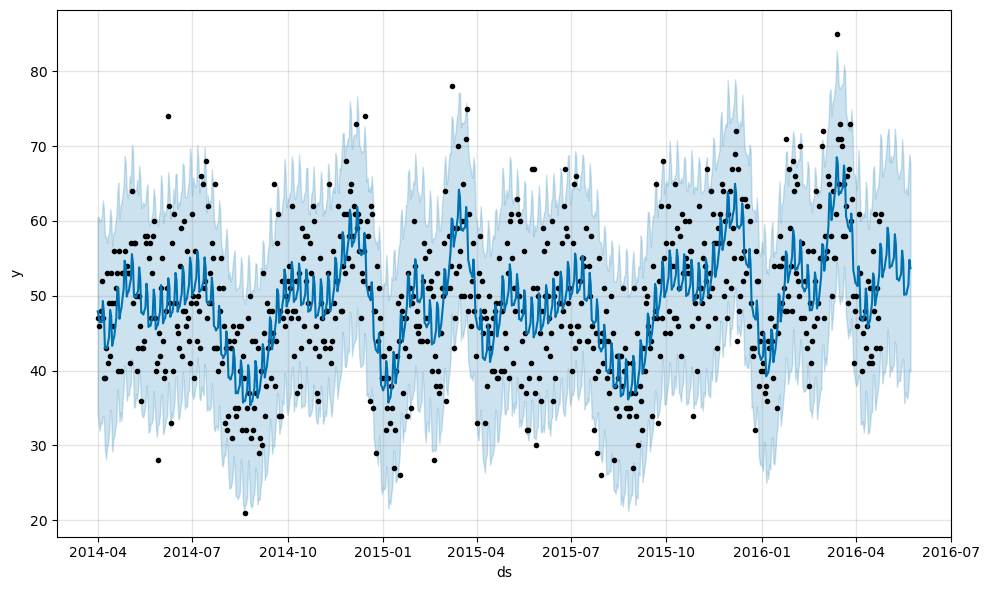

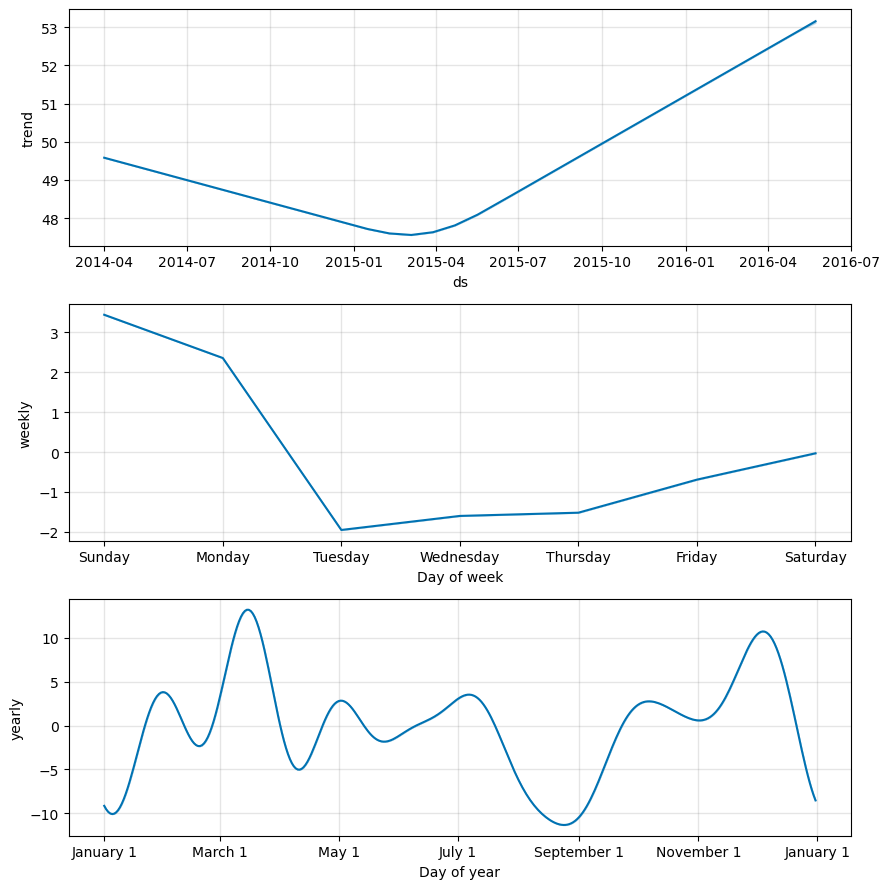

In [66]:
basic_prophet = Prophet(interval_width=0.95)
basic_prophet.fit(prophet_train)
future_df = basic_prophet.make_future_dataframe(periods=PERIODS)
basic_p_fcst = basic_prophet.predict(future_df)
fig1 = basic_prophet.plot(basic_p_fcst)
fig2 = basic_prophet.plot_components(basic_p_fcst)

##### Cross-validation of Prophet model using folds identical to previous evaluations of ARIMA and Naive models

In [67]:
# Creating cut-off DateTime indexes for cross-validation folds
generator = rolling_forecast_origin(train_ed, test_ed, horizon=28)
cutoffs = []
for train, test in generator:
    cutoffs.append(train.iloc[-1].name)
cutoffs = pd.to_datetime(cutoffs)

In [68]:
cutoffs

DatetimeIndex(['2016-04-25', '2016-06-06', '2016-07-18', '2016-08-29',
               '2016-10-10', '2016-11-21'],
              dtype='datetime64[ns]', freq=None)

In [69]:
# Fitting the basic model twice with different prediction Intervals,
    # as there is not a way to set this parameter after creating an instance
HORIZON = '28 days'
for i,pred_int in enumerate([0.8, 0.95]):
    
    basic_prophet= Prophet(interval_width=pred_int)
    
    # Creating an evaluation DataFrame 
    cv_df = cv_prophet_model(basic_prophet, prophet_ed, cutoffs, 
                             horizon=HORIZON, pred_int=pred_int,
                            name='basic_Prophet')
    
    if i ==0:
        df1 = cv_df
        
    elif i ==1:
        merged_basic_df = pd.merge(df1, cv_df)
        merged_basic_df.index = cv_df.index

12:57:16 - cmdstanpy - INFO - Chain [1] start processing
12:57:16 - cmdstanpy - INFO - Chain [1] done processing
12:57:16 - cmdstanpy - INFO - Chain [1] start processing
12:57:16 - cmdstanpy - INFO - Chain [1] done processing
12:57:16 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1] done processing
12:57:17 - cmdstanpy - INFO - Chain [1] start processing
12:57:17 - cmdstanpy - INFO - Chain [1]

In [70]:
evals = add_prophet_evals(merged_basic_df, evals)

In [71]:
evals.T

RMSE    MAE    MAPE  Coverage_80  \
basic_Prophet                           6.516  5.288  11.509        0.812   
Average()_avg                           9.310  7.502  15.001        0.798   
 ARIMA(0,1,1)(0,0,2)[7]          _avg   7.728  6.304  12.655        0.850   
 ARIMA(0,1,1)(2,0,0)[7]          _avg   7.728  6.296  12.627        0.850   
 ARIMA(7,0,1)(0,1,1)[7]          _avg   7.502  6.049  11.753        0.883   
 ARIMA(14,0,1)(0,1,1)[7]          _avg  7.467  6.071  11.827        0.883   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg   7.930  6.332  12.501        0.850   
 ARIMA(0,1,1)(0,0,4)[7]          _avg   7.654  6.228  12.525        0.850   

                                        Winkler_Score_80  Coverage_95  \
basic_Prophet                                     29.560        1.000   
Average()_avg                                     34.585        0.958   
 ARIMA(0,1,1)(0,0,2)[7]          _avg             29.523        0.950   
 ARIMA(0,1,1)(2,0,0)[7]          _avg             29.541        0.950   
 ARIMA(7,0,1)(0,1,1)[7]          _avg             29.274        0.950   
 ARIMA(14,0,1)(0,1,1)[7]          _avg            28.839        0.950   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             30.010        0.933   
 ARIMA(0,1,1)(0,0,4)[7]          _avg             29.029        0.950   

                                        Winkler_Score_95  
basic_Prophet                                     41.831  
Average()_avg                                     48.145  
 ARIMA(0,1,1)(0,0,2)[7]          _avg             41.616  
 ARIMA(0,1,1)(2,0,0)[7]          _avg             41.632  
 ARIMA(7,0,1)(0,1,1)[7]          _avg             43.309  
 ARIMA(14,0,1)(0,1,1)[7]          _avg            41.896  
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             43.011  
 ARIMA(0,1,1)(0,0,4)[7]          _avg             40.995

### 5.2 Adding UK Holidays to Prophet: plotting and cross validation <a id='5.2'></a>

12:57:18 - cmdstanpy - INFO - Chain [1] start processing
12:57:19 - cmdstanpy - INFO - Chain [1] done processing


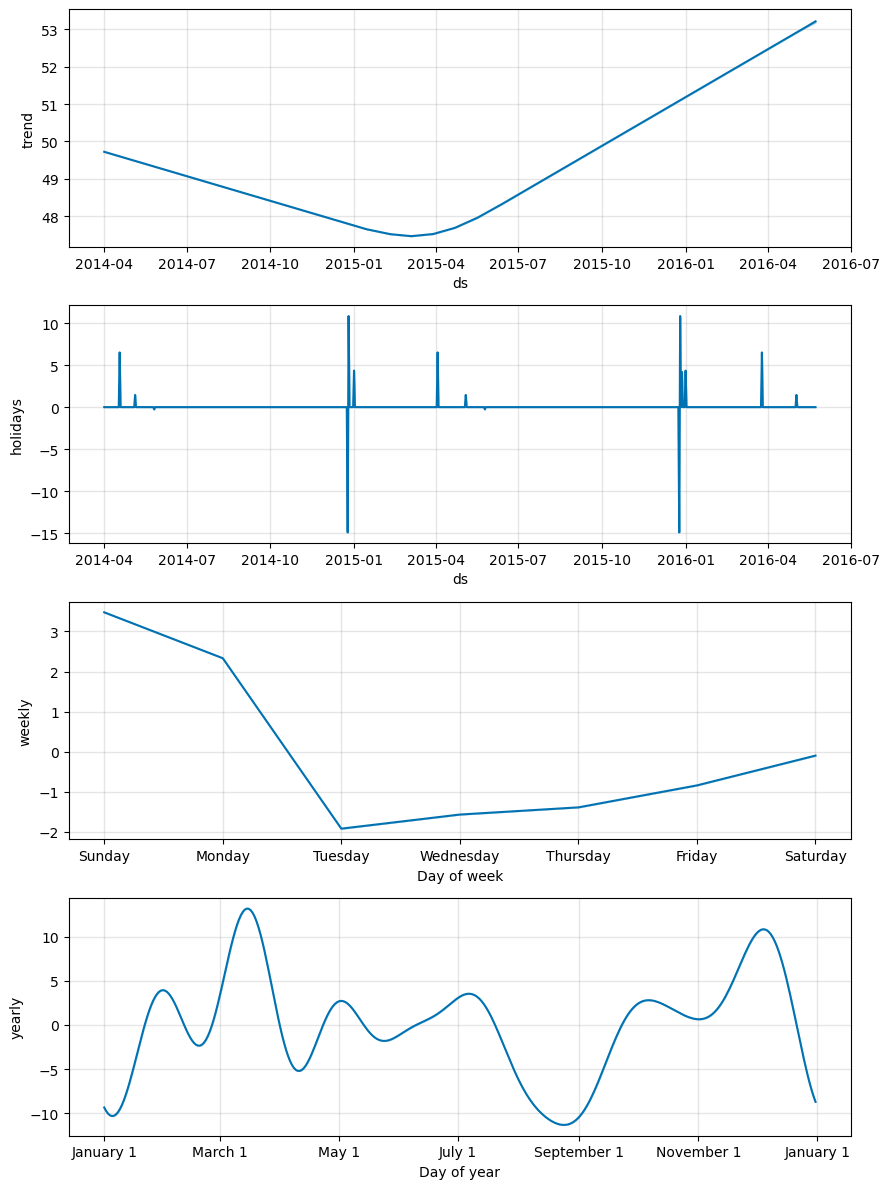

In [72]:
ukhols_prophet = Prophet(interval_width=0.95)
ukhols_prophet.add_country_holidays(country_name='UK')
ukhols_prophet.fit(prophet_train)

future_df = ukhols_prophet.make_future_dataframe(periods=PERIODS)
ukhols_p_fcst = ukhols_prophet.predict(future_df)
fig2 = ukhols_prophet.plot_components(ukhols_p_fcst)

##### Prophet with UK Holidays Plot; <a id="ukhols_prophet">

In [73]:
plot_plotly(ukhols_prophet, ukhols_p_fcst)

In [74]:
# Inspecting which Holidays are included as a default:
ukhols_prophet.train_holiday_names

0              New Year's Day
1               Christmas Day
2    Christmas Day (Observed)
3                  Boxing Day
4                 Good Friday
5                     May Day
6         Spring Bank Holiday
7       Boxing Day (Observed)
dtype: object

In [75]:
for i,pred_int in enumerate([0.8, 0.95]):
    merged_df = pd.DataFrame()
    
    ukhols_prophet= Prophet(interval_width=pred_int)
    ukhols_prophet.add_country_holidays(country_name='UK')
    
    
    # Creating an evaluation DataFrame 
    cv_df = cv_prophet_model(ukhols_prophet, prophet_ed, cutoffs, 
                             horizon=HORIZON, pred_int=pred_int,
                             name='UKhol_Prophet')
    
    if i ==0:
        df1 = cv_df
        
    elif i ==1:
        merged_df = pd.merge(df1, cv_df)
        merged_df.index = cv_df.index

12:57:20 - cmdstanpy - INFO - Chain [1] start processing
12:57:20 - cmdstanpy - INFO - Chain [1] done processing
12:57:20 - cmdstanpy - INFO - Chain [1] start processing
12:57:20 - cmdstanpy - INFO - Chain [1] done processing
12:57:20 - cmdstanpy - INFO - Chain [1] start processing
12:57:20 - cmdstanpy - INFO - Chain [1] done processing
12:57:20 - cmdstanpy - INFO - Chain [1] start processing
12:57:20 - cmdstanpy - INFO - Chain [1] done processing
12:57:20 - cmdstanpy - INFO - Chain [1] start processing
12:57:20 - cmdstanpy - INFO - Chain [1] done processing
12:57:20 - cmdstanpy - INFO - Chain [1] start processing
12:57:21 - cmdstanpy - INFO - Chain [1] done processing
12:57:21 - cmdstanpy - INFO - Chain [1] start processing
12:57:21 - cmdstanpy - INFO - Chain [1] done processing
12:57:21 - cmdstanpy - INFO - Chain [1] start processing
12:57:21 - cmdstanpy - INFO - Chain [1] done processing
12:57:21 - cmdstanpy - INFO - Chain [1] start processing
12:57:21 - cmdstanpy - INFO - Chain [1]

In [76]:
evals = add_prophet_evals(merged_df, evals)

In [77]:
evals.T

RMSE    MAE    MAPE  Coverage_80  \
UKhol_Prophet                           6.598  5.318  11.594        0.771   
basic_Prophet                           6.516  5.288  11.509        0.812   
Average()_avg                           9.310  7.502  15.001        0.798   
 ARIMA(0,1,1)(0,0,2)[7]          _avg   7.728  6.304  12.655        0.850   
 ARIMA(0,1,1)(2,0,0)[7]          _avg   7.728  6.296  12.627        0.850   
 ARIMA(7,0,1)(0,1,1)[7]          _avg   7.502  6.049  11.753        0.883   
 ARIMA(14,0,1)(0,1,1)[7]          _avg  7.467  6.071  11.827        0.883   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg   7.930  6.332  12.501        0.850   
 ARIMA(0,1,1)(0,0,4)[7]          _avg   7.654  6.228  12.525        0.850   

                                        Winkler_Score_80  Coverage_95  \
UKhol_Prophet                                     29.534        1.000   
basic_Prophet                                     29.560        1.000   
Average()_avg                                     34.585        0.958   
 ARIMA(0,1,1)(0,0,2)[7]          _avg             29.523        0.950   
 ARIMA(0,1,1)(2,0,0)[7]          _avg             29.541        0.950   
 ARIMA(7,0,1)(0,1,1)[7]          _avg             29.274        0.950   
 ARIMA(14,0,1)(0,1,1)[7]          _avg            28.839        0.950   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             30.010        0.933   
 ARIMA(0,1,1)(0,0,4)[7]          _avg             29.029        0.950   

                                        Winkler_Score_95  
UKhol_Prophet                                     42.924  
basic_Prophet                                     41.831  
Average()_avg                                     48.145  
 ARIMA(0,1,1)(0,0,2)[7]          _avg             41.616  
 ARIMA(0,1,1)(2,0,0)[7]          _avg             41.632  
 ARIMA(7,0,1)(0,1,1)[7]          _avg             43.309  
 ARIMA(14,0,1)(0,1,1)[7]          _avg            41.896  
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             43.011  
 ARIMA(0,1,1)(0,0,4)[7]          _avg             40.995

### 5.3 Prophet with more rigid trend changepoints <a id='5.3'></a>
Looking at the Basic Prophet trend and seasonality, there is an inflection of the trend in 2015.
AS there are only two years of data, this may an over-fitted trend

12:57:22 - cmdstanpy - INFO - Chain [1] start processing
12:57:22 - cmdstanpy - INFO - Chain [1] done processing


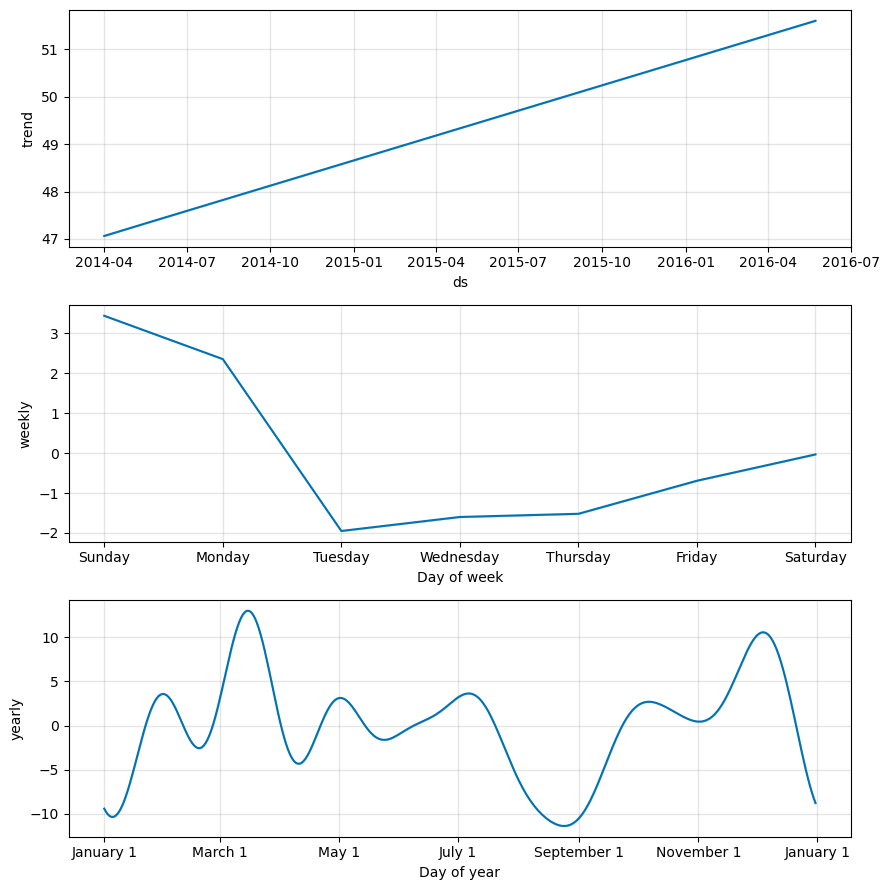

In [78]:
# Default changepoint_prior_scale is 0.05, let's divide it by 10
# As adding UK Holidays did not improve the model based on CV, we will not add them now

rigid_prophet = Prophet(interval_width=0.95, changepoint_prior_scale = 0.005) 
rigid_prophet.fit(prophet_train)
future_df = rigid_prophet.make_future_dataframe(periods=PERIODS)
rigid_p_fcst = rigid_prophet.predict(future_df)
fig2 = rigid_prophet.plot_components(rigid_p_fcst)

##### The trend has been transformed to a continuous linear increase
##### As expected, plotting changepoint reveals that none were fitted

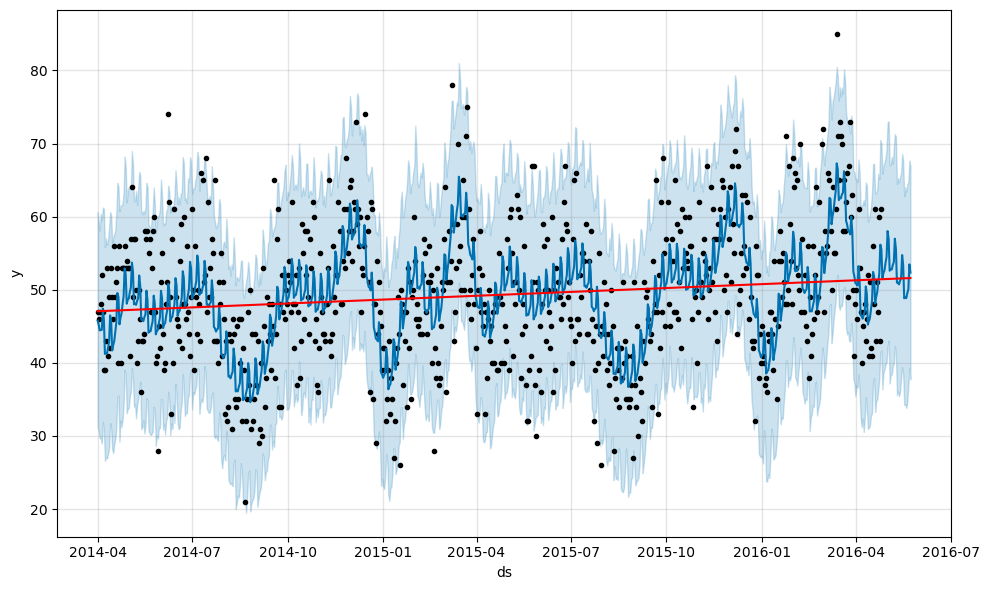

In [79]:
fig1 = rigid_prophet.plot(rigid_p_fcst)
a = add_changepoints_to_plot(fig1.gca(), rigid_prophet, rigid_p_fcst)

In [80]:
for i,pred_int in enumerate([0.8, 0.95]):
    merged_df = pd.DataFrame()
    
    rigid_prophet = Prophet(interval_width=pred_int, changepoint_prior_scale = 0.005)
    
    
    # Creating an evaluation DataFrame 
    cv_df = cv_prophet_model(rigid_prophet, prophet_ed, cutoffs, 
                             horizon=HORIZON, pred_int=pred_int,
                             name='rigid_Prophet')
    
    if i ==0:
        df1 = cv_df
        
    elif i ==1:
        merged_df = pd.merge(df1, cv_df)
        merged_df.index = cv_df.index
        
evals = add_prophet_evals(merged_df, evals)
evals.T 

12:57:23 - cmdstanpy - INFO - Chain [1] start processing
12:57:23 - cmdstanpy - INFO - Chain [1] done processing
12:57:23 - cmdstanpy - INFO - Chain [1] start processing
12:57:23 - cmdstanpy - INFO - Chain [1] done processing
12:57:23 - cmdstanpy - INFO - Chain [1] start processing
12:57:23 - cmdstanpy - INFO - Chain [1] done processing
12:57:23 - cmdstanpy - INFO - Chain [1] start processing
12:57:23 - cmdstanpy - INFO - Chain [1] done processing
12:57:24 - cmdstanpy - INFO - Chain [1] start processing
12:57:24 - cmdstanpy - INFO - Chain [1] done processing
12:57:24 - cmdstanpy - INFO - Chain [1] start processing
12:57:24 - cmdstanpy - INFO - Chain [1] done processing
12:57:24 - cmdstanpy - INFO - Chain [1] start processing
12:57:24 - cmdstanpy - INFO - Chain [1] done processing
12:57:24 - cmdstanpy - INFO - Chain [1] start processing
12:57:24 - cmdstanpy - INFO - Chain [1] done processing
12:57:24 - cmdstanpy - INFO - Chain [1] start processing
12:57:24 - cmdstanpy - INFO - Chain [1]

RMSE    MAE    MAPE  Coverage_80  \
rigid_Prophet                           6.470  5.316  11.467        0.833   
UKhol_Prophet                           6.598  5.318  11.594        0.771   
basic_Prophet                           6.516  5.288  11.509        0.812   
Average()_avg                           9.310  7.502  15.001        0.798   
 ARIMA(0,1,1)(0,0,2)[7]          _avg   7.728  6.304  12.655        0.850   
 ARIMA(0,1,1)(2,0,0)[7]          _avg   7.728  6.296  12.627        0.850   
 ARIMA(7,0,1)(0,1,1)[7]          _avg   7.502  6.049  11.753        0.883   
 ARIMA(14,0,1)(0,1,1)[7]          _avg  7.467  6.071  11.827        0.883   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg   7.930  6.332  12.501        0.850   
 ARIMA(0,1,1)(0,0,4)[7]          _avg   7.654  6.228  12.525        0.850   

                                        Winkler_Score_80  Coverage_95  \
rigid_Prophet                                     28.918        0.938   
UKhol_Prophet                                     29.534        1.000   
basic_Prophet                                     29.560        1.000   
Average()_avg                                     34.585        0.958   
 ARIMA(0,1,1)(0,0,2)[7]          _avg             29.523        0.950   
 ARIMA(0,1,1)(2,0,0)[7]          _avg             29.541        0.950   
 ARIMA(7,0,1)(0,1,1)[7]          _avg             29.274        0.950   
 ARIMA(14,0,1)(0,1,1)[7]          _avg            28.839        0.950   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             30.010        0.933   
 ARIMA(0,1,1)(0,0,4)[7]          _avg             29.029        0.950   

                                        Winkler_Score_95  
rigid_Prophet                                     40.730  
UKhol_Prophet                                     42.924  
basic_Prophet                                     41.831  
Average()_avg                                     48.145  
 ARIMA(0,1,1)(0,0,2)[7]          _avg             41.616  
 ARIMA(0,1,1)(2,0,0)[7]          _avg             41.632  
 ARIMA(7,0,1)(0,1,1)[7]          _avg             43.309  
 ARIMA(14,0,1)(0,1,1)[7]          _avg            41.896  
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             43.011  
 ARIMA(0,1,1)(0,0,4)[7]          _avg             40.995

### 5.4 Prophet with Higher Fourier Order for Seasonalities <a id='5.4'></a>
It has been shown before that yearly seasonality is important in paediatric ED admission.
As there are multiple drivers of this seasonality (spring and summer holidays for ED admission),
seasonal infections, sports seasons etc, a model that could capture these seasonal patters in more detail
could perform better.

12:57:25 - cmdstanpy - INFO - Chain [1] start processing
12:57:25 - cmdstanpy - INFO - Chain [1] done processing


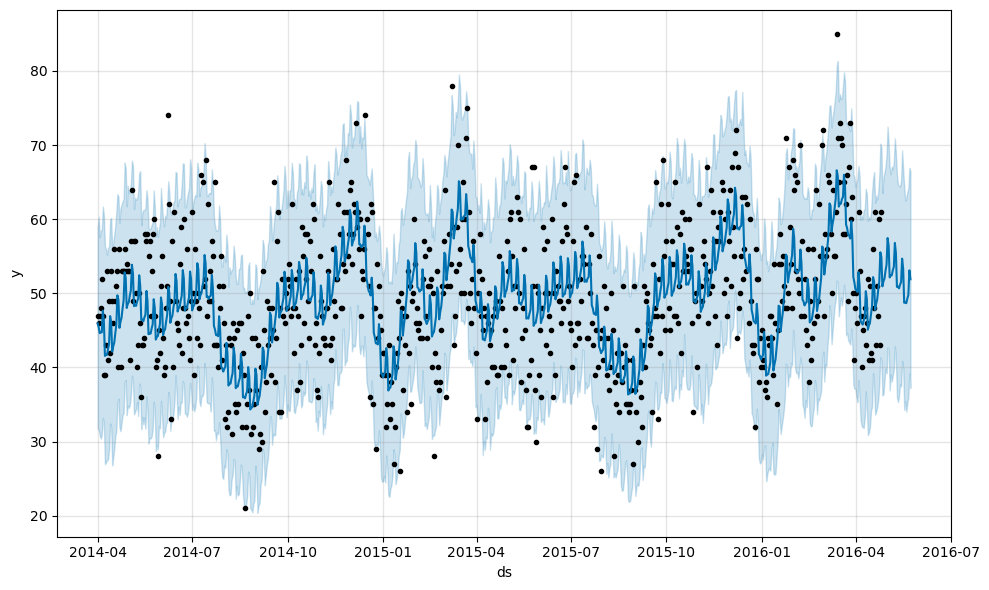

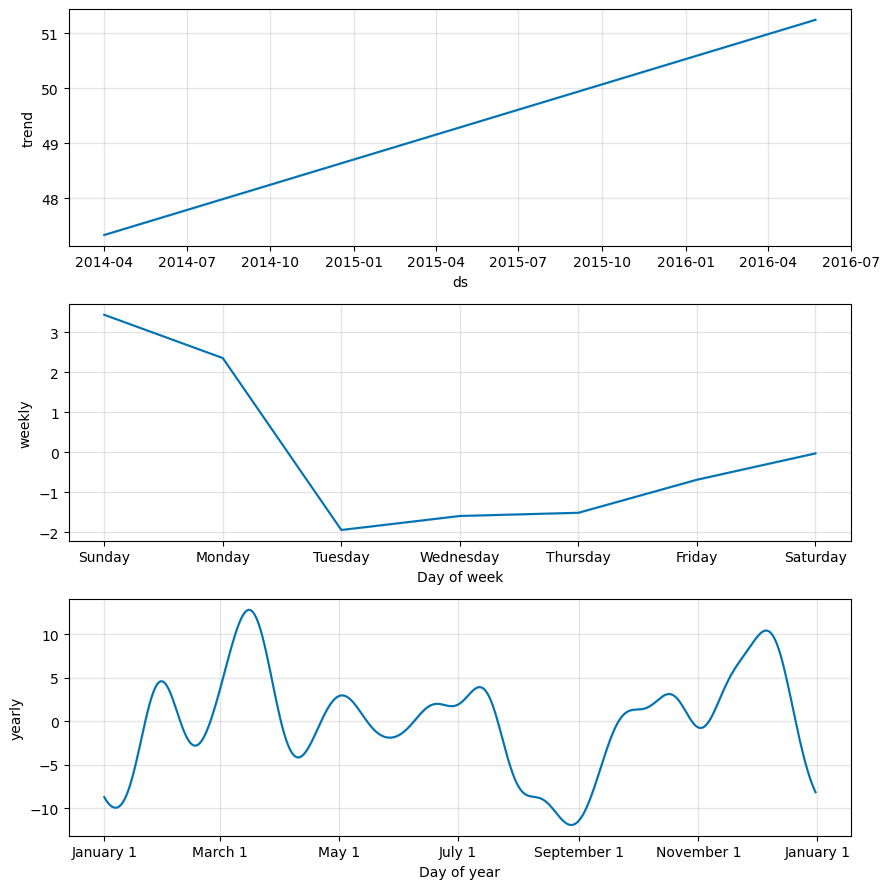

In [81]:
# Increasing the Fourier Order from 10 ('auto') to 15
rigid_prophet_sa = Prophet(interval_width=0.95,
                           changepoint_prior_scale = 0.005,
                           yearly_seasonality=15)

rigid_prophet_sa.fit(prophet_train)
future_df = rigid_prophet_sa.make_future_dataframe(periods=PERIODS)
rigid_sa_p_fcst = rigid_prophet_sa.predict(future_df)
fig1 = rigid_prophet_sa.plot(rigid_sa_p_fcst);
fig2 = rigid_prophet_sa.plot_components(rigid_sa_p_fcst)

In [82]:
for i,pred_int in enumerate([0.8, 0.95]):
    merged_df = pd.DataFrame()
    
    rigid_prophet_sa = Prophet(interval_width=pred_int,
                               changepoint_prior_scale = 0.005,
                               yearly_seasonality=15)
    
    # Creating an evaluation DataFrame 
    cv_df = cv_prophet_model(rigid_prophet_sa, prophet_ed, cutoffs, 
                             horizon=HORIZON, pred_int=pred_int,
                             name='rigid_Prophet_ys15')
    
    if i ==0:
        df1 = cv_df
        
    elif i ==1:
        merged_df = pd.merge(df1, cv_df)
        merged_df.index = cv_df.index
        
evals = add_prophet_evals(merged_df, evals)
evals.T 

12:57:26 - cmdstanpy - INFO - Chain [1] start processing
12:57:26 - cmdstanpy - INFO - Chain [1] done processing
12:57:26 - cmdstanpy - INFO - Chain [1] start processing
12:57:26 - cmdstanpy - INFO - Chain [1] done processing
12:57:26 - cmdstanpy - INFO - Chain [1] start processing
12:57:26 - cmdstanpy - INFO - Chain [1] done processing
12:57:26 - cmdstanpy - INFO - Chain [1] start processing
12:57:26 - cmdstanpy - INFO - Chain [1] done processing
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1] done processing
12:57:27 - cmdstanpy - INFO - Chain [1] start processing
12:57:27 - cmdstanpy - INFO - Chain [1]

RMSE    MAE    MAPE  Coverage_80  \
rigid_Prophet_ys15                      6.236  5.162  11.164        0.875   
rigid_Prophet                           6.470  5.316  11.467        0.833   
UKhol_Prophet                           6.598  5.318  11.594        0.771   
basic_Prophet                           6.516  5.288  11.509        0.812   
Average()_avg                           9.310  7.502  15.001        0.798   
 ARIMA(0,1,1)(0,0,2)[7]          _avg   7.728  6.304  12.655        0.850   
 ARIMA(0,1,1)(2,0,0)[7]          _avg   7.728  6.296  12.627        0.850   
 ARIMA(7,0,1)(0,1,1)[7]          _avg   7.502  6.049  11.753        0.883   
 ARIMA(14,0,1)(0,1,1)[7]          _avg  7.467  6.071  11.827        0.883   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg   7.930  6.332  12.501        0.850   
 ARIMA(0,1,1)(0,0,4)[7]          _avg   7.654  6.228  12.525        0.850   

                                        Winkler_Score_80  Coverage_95  \
rigid_Prophet_ys15                                28.370        1.000   
rigid_Prophet                                     28.918        0.938   
UKhol_Prophet                                     29.534        1.000   
basic_Prophet                                     29.560        1.000   
Average()_avg                                     34.585        0.958   
 ARIMA(0,1,1)(0,0,2)[7]          _avg             29.523        0.950   
 ARIMA(0,1,1)(2,0,0)[7]          _avg             29.541        0.950   
 ARIMA(7,0,1)(0,1,1)[7]          _avg             29.274        0.950   
 ARIMA(14,0,1)(0,1,1)[7]          _avg            28.839        0.950   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             30.010        0.933   
 ARIMA(0,1,1)(0,0,4)[7]          _avg             29.029        0.950   

                                        Winkler_Score_95  
rigid_Prophet_ys15                                41.876  
rigid_Prophet                                     40.730  
UKhol_Prophet                                     42.924  
basic_Prophet                                     41.831  
Average()_avg                                     48.145  
 ARIMA(0,1,1)(0,0,2)[7]          _avg             41.616  
 ARIMA(0,1,1)(2,0,0)[7]          _avg             41.632  
 ARIMA(7,0,1)(0,1,1)[7]          _avg             43.309  
 ARIMA(14,0,1)(0,1,1)[7]          _avg            41.896  
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             43.011  
 ARIMA(0,1,1)(0,0,4)[7]          _avg             40.995

### 5.5 Adding custom changepoints based on Public Health England Historic Influenza Like Illness Surveillence <a id='5.5'></a>
From https://webarchive.nationalarchives.gov.uk/ukgwa/20220401215804/https:/www.gov.uk/government/statistics/annual-flu-reports
Changepoints are defined as more than 100% increase in consultantsions, and then as 50% decrease from peak value for each year.

###### PHE England did not have continuous data available that would be suitable for an external regressor, only extractable from etiher a graph, or 52*4 weekly report PDFs that all in different formats

12:57:28 - cmdstanpy - INFO - Chain [1] start processing
12:57:28 - cmdstanpy - INFO - Chain [1] done processing


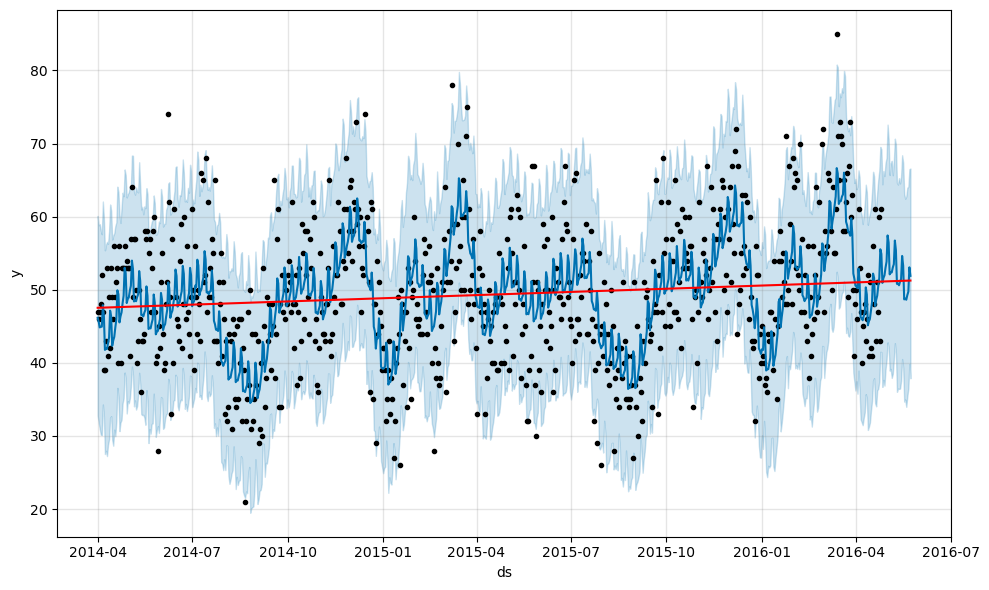

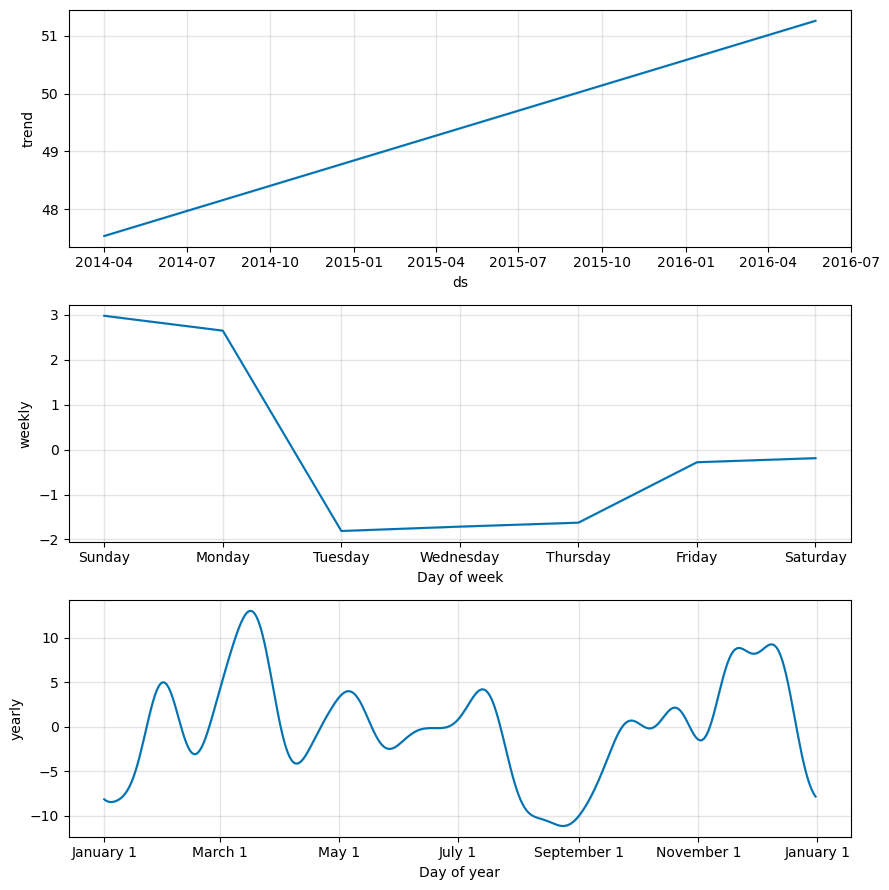

In [83]:
rigid_prophet_sa_CP = Prophet(interval_width=pred_int,
                              changepoint_prior_scale = 0.005,
                              yearly_seasonality=15,
                              changepoints = ['2014-12-07', '2015-01-21',
                                              '2016-01-21', '2016-03-14']
                                   )
rigid_prophet_sa_CP.add_country_holidays('US')
rigid_prophet_sa_CP.fit(prophet_train)
future_df = rigid_prophet_sa_CP.make_future_dataframe(periods=PERIODS)
rigid_CP_p_fcst = rigid_prophet_sa_CP.predict(future_df)
fig1 = rigid_prophet_sa_CP.plot(rigid_CP_p_fcst);
a =add_changepoints_to_plot(fig1.gca(), rigid_prophet_sa_CP, rigid_CP_p_fcst)
fig2 = rigid_prophet_sa.plot_components(rigid_CP_p_fcst)

In [84]:
for i,pred_int in enumerate([0.8, 0.95]):
    merged_df = pd.DataFrame()
    
    rigid_prophet_sa_CP = Prophet(interval_width=pred_int,
                               changepoint_prior_scale = 0.005,
                               yearly_seasonality=15,
                               changepoints = ['2014-12-07', '2015-01-21',
                                               '2016-01-21', '2016-03-14']
                              )

    
    # Creating an evaluation DataFrame 
    cv_df = cv_prophet_model(rigid_prophet_sa_CP, prophet_ed, cutoffs, 
                             horizon=HORIZON, pred_int=pred_int,
                             name='rigid_Prophet_ys15_cCP')
    
    if i ==0:
        df1 = cv_df
        
    elif i ==1:
        merged_df = pd.merge(df1, cv_df)
        merged_df.index = cv_df.index
merged_df

12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing
12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing
12:57:29 - cmdstanpy - INFO - Chain [1] start processing
12:57:29 - cmdstanpy - INFO - Chain [1] done processing
12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing
12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing
12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing
12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing
12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:30 - cmdstanpy - INFO - Chain [1] done processing
12:57:30 - cmdstanpy - INFO - Chain [1] start processing
12:57:31 - cmdstanpy - INFO - Chain [1]

RMSE    MAE    MAPE  Coverage_80  Winkler_Score_80  \
rigid_Prophet_ys15_cCP  6.211  5.154  11.116        0.875            28.401   

                        Coverage_95  Winkler_Score_95  
rigid_Prophet_ys15_cCP          1.0            40.669

In [85]:
evals = add_prophet_evals(merged_df, evals)


In [86]:
evals.T

RMSE    MAE    MAPE  Coverage_80  \
rigid_Prophet_ys15_cCP                  6.211  5.154  11.116        0.875   
rigid_Prophet_ys15                      6.236  5.162  11.164        0.875   
rigid_Prophet                           6.470  5.316  11.467        0.833   
UKhol_Prophet                           6.598  5.318  11.594        0.771   
basic_Prophet                           6.516  5.288  11.509        0.812   
Average()_avg                           9.310  7.502  15.001        0.798   
 ARIMA(0,1,1)(0,0,2)[7]          _avg   7.728  6.304  12.655        0.850   
 ARIMA(0,1,1)(2,0,0)[7]          _avg   7.728  6.296  12.627        0.850   
 ARIMA(7,0,1)(0,1,1)[7]          _avg   7.502  6.049  11.753        0.883   
 ARIMA(14,0,1)(0,1,1)[7]          _avg  7.467  6.071  11.827        0.883   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg   7.930  6.332  12.501        0.850   
 ARIMA(0,1,1)(0,0,4)[7]          _avg   7.654  6.228  12.525        0.850   

                                        Winkler_Score_80  Coverage_95  \
rigid_Prophet_ys15_cCP                            28.401        1.000   
rigid_Prophet_ys15                                28.370        1.000   
rigid_Prophet                                     28.918        0.938   
UKhol_Prophet                                     29.534        1.000   
basic_Prophet                                     29.560        1.000   
Average()_avg                                     34.585        0.958   
 ARIMA(0,1,1)(0,0,2)[7]          _avg             29.523        0.950   
 ARIMA(0,1,1)(2,0,0)[7]          _avg             29.541        0.950   
 ARIMA(7,0,1)(0,1,1)[7]          _avg             29.274        0.950   
 ARIMA(14,0,1)(0,1,1)[7]          _avg            28.839        0.950   
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             30.010        0.933   
 ARIMA(0,1,1)(0,0,4)[7]          _avg             29.029        0.950   

                                        Winkler_Score_95  
rigid_Prophet_ys15_cCP                            40.669  
rigid_Prophet_ys15                                41.876  
rigid_Prophet                                     40.730  
UKhol_Prophet                                     42.924  
basic_Prophet                                     41.831  
Average()_avg                                     48.145  
 ARIMA(0,1,1)(0,0,2)[7]          _avg             41.616  
 ARIMA(0,1,1)(2,0,0)[7]          _avg             41.632  
 ARIMA(7,0,1)(0,1,1)[7]          _avg             43.309  
 ARIMA(14,0,1)(0,1,1)[7]          _avg            41.896  
 ARIMA(1,1,1)(1,1,1)[7] intercept_avg             43.011  
 ARIMA(0,1,1)(0,0,4)[7]          _avg             40.995

In [87]:
int(.875*28*6 - .833*28*6)

7

# 6. Neural Network Predictions <a id='16'></a>
0. [NN and LSTM Functions](#6.0)
1. [Pre-precessing data](#6.1)
2. [Fitting simple FF-NNs](#6.2)
3. [Fit and Evaluate LSTM](#6.3)

#### 6.0 NN and LSTM Functions <a id='6.0'></a>

##### Plotting functions

In [88]:
def plot_NN_history(model_fit_results, validation=False):
    
    plt.plot(model_fit_results.history['loss'], label='loss')
    if validation:
        plt.plot(model_fit_results.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [89]:
def plot_fitted_NN(model, X_train, y_train, scaler,
                   index=0, horizon=28, lstm_dim=None):

        
    if (lstm_dim is None) or lstm_dim<=1:
        y_preds = model.predict(X_train[index]
                                .reshape(1, -1))[0]
    elif lstm_dim > 1:
        y_preds = model.predict(X_train[index-1:index])[0]
    #    print(X_train[index-1:index].shape)
        
    y_preds = (scaler
               .inverse_transform(y_preds.reshape(-1, 1))
               .reshape(-1, ))

    truth = (scaler
             .inverse_transform(y_train[index].reshape(-1, 1))
             .reshape(-1, ))
    
    
    x_index = np.arange(index*horizon, )
    plt.plot(truth, label='ground truth')
    plt.plot(y_preds, label='NN fitted')
    plt.legend()
    plt.show();

In [90]:
def plot_nn_prediction_results(model, X_train, y_train, y_test, y_preds):  
    '''
    utility function to plot the results of the prediction
    '''
    #create series
    fitted_values = scaler.inverse_transform(model.predict(X_train))
    ground_truth = scaler.inverse_transform(y_train)
#    ground_truth_val = scaler.inverse_transform(y_test)
    ground_truth_val = np.array(y_test)

    padding = np.full(len(fitted_values), np.NAN)

    validation = np.concatenate([padding.reshape(-1, 1), ground_truth_val])
    forecast = np.concatenate([padding.reshape(-1, 1), y_preds])

    plt.plot(ground_truth, label='ground truth')
    plt.plot(validation, label='test')
    plt.plot(fitted_values, label='in-sample', linestyle='-.')
    plt.plot(forecast, label='out-of-sample', linestyle='-.')
#    plt.plot(admit_rate.to_numpy()[12:])
    plt.legend();

##### Data wrangling and cross-validation

In [91]:
def sliding_window_tab(train, window_size=28, horizon=28, step=14,
                       lstm=False, add_date_features=False,
                       y_col_name='paed_ed_attends'):
    '''
    Generate sliding window datasets for time series forecasting.

    Parameters:
    -----------
    train : DataFrame
        Training data for time series modeling.

    window_size : int, optional (default=28)
        Lookback - how much lagged data to include.

    horizon : int, optional (default=28)
        Number of observations ahead to predict.

    step : int, optional (default=14)
        Step size for sliding the window.

    lstm : bool, optional (default=False)
        If True, generates data for LSTM models;
        if False, generates data for tabular models.

    add_date_features : bool, optional (default=False)
        If True, adds date-related features
        (month, week of the month, day of the week) to input data.

    y_col_name : str, optional (default='paed_ed_attends')
        Column name for the target variable.

    Returns:
    --------
    preprocessed X, preprocessed Y as NumPy arrays.
    Shape of X: (num_samples, window_size, num_features)
    Shape of Y: (num_samples, horizon)
    '''

    tabular_X = []
    tabular_y = []

    if not lstm:
        train = np.asarray(train).reshape(-1, )

    if lstm and add_date_features:
        train = train.reset_index()

    for i in range(0, len(train) - window_size - horizon + 1, step):
        split_index = window_size + i
        X_train = train[i:split_index]

        if add_date_features:
            # Extract month, week of the month, and day of the week
            X_train['month'] = X_train['date'].dt.month
            X_train['week_of_month'] = X_train['date'].dt.isocalendar().week
            X_train['day_of_week'] = X_train['date'].dt.dayofweek
            # Drop date after extracting features
            X_train = X_train.drop(columns=['date'])

            y_train = train[y_col_name][split_index:split_index + horizon]

        if not add_date_features:
            y_train = train[split_index:split_index + horizon]

        tabular_X.append(X_train.astype('float32'))
        tabular_y.append(y_train.astype('float32'))

    # Convert lists to NumPy arrays with the right shapes
    tabular_X = np.asarray(tabular_X)
    tabular_y = np.asarray(tabular_y)
    print(tabular_X.shape)
    print(tabular_y.shape)

    return np.asarray(tabular_X), np.asarray(tabular_y)

In [92]:
def cross_validate_NN_preds(model, x_test, y_test,
                            name='defaultNN', scaler=None,
                            lstm=False):
    """
    Cross-validate neural network predictions and
        concatenate fold evaluations into a DataFrame.

    Parameters:
    -----------
    model : object
        Trained neural network model.

    x_test : array-like
        Test input data.

    y_test : array-like
        Test target data.

    name : str, optional (default='defaultNN')
        Name for the model.

    scaler : object, optional (default=None)
        Scaler object used for scaling the data.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing evaluation metrics.
    """
    overall_eval = pd.DataFrame()

    for i in range(len(X_test)):
        # Generate predictions and ground truth
        print(x_test[i:i+1].shape)
        # if lstm:
        #     y_pred =  model.predict(X_train[i:i+1])
        # elif not lstm:
        #     y_pred = 
            
        y_preds = (scaler
                   .inverse_transform(model
                                      .predict(X_train[i].reshape(1, -1)
                                              if not lstm else
                                              X_train[i:i+1]))
                   .ravel()
                  )
        truth = (scaler
                 .inverse_transform(y_test[i].reshape(-1, 1))
                 .ravel()
                )

        # Evaluate predictions for the current fold
        fold_eval = evaluate_prediction(df=None, name=f'{name}_{i}',
                                        true_col=truth,
                                        pred_col=y_preds,
                                        lower_col_80=None,
                                        lower_col_95=None)
        # print(fold_eval)
  
        # Concatenate evaluation metrics for each fold
        overall_eval = pd.concat([overall_eval, fold_eval], axis=0)

    return overall_eval

##### Neural nets assembler functions

In [93]:
# Create a simple LSTM model
def create_lstm_model(input_shape, horizon=28, metrics=None,
                      lstm_units = 28, lr=0.01, lstm_activation='tanh'):
    
    if metrics is None:
        metrics = ['mse']
    
    model = Sequential([
        Input(shape=input_shape),
        LSTM(units=lstm_units, input_shape=input_shape,
             activation=lstm_activation),
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mse'])
    return model

In [94]:
def get_network_model(ws, outputs, n_neurons_l1=32, n_neurons_l2=64,
                      include_layer_two=False, include_drop_out=False,
                      drop_out_rate=0.2, lr=0.01, metrics=None):
    '''
    A function to allow quick changing of network parameters
    '''
    if metrics is None:
        metrics = ['mse']
        
    model = Sequential()
    model.add(Flatten(input_shape=(ws,)))
    model.add(Dense(n_neurons_l1, activation='relu'))
    if include_layer_two:
        model.add(Dense(n_neurons_l2, activation='relu'))
    if include_drop_out:
        model.add(Dropout(drop_out_rate))
    model.add(Dense(outputs))
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=lr),
                  metrics=metrics)
    return model

#### 6.1 Pre-precessing data <a id='6.1'></a>

In [95]:
# Preprocessing data
scaler = MinMaxScaler(feature_range=(-1, 1))

# scale on training data
scaler.fit(train_ed.to_numpy().reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [96]:
scaled_train_ed = train_ed.copy()
scaled_train_ed['paed_ed_attends'] = scaler.transform(scaled_train_ed['paed_ed_attends'].to_numpy().reshape(-1, 1))

scaled_test_ed = test_ed.copy()
scaled_test_ed['paed_ed_attends'] = scaler.transform(scaled_test_ed['paed_ed_attends'].to_numpy().reshape(-1, 1))

scaled_all = ed_data.copy()
scaled_all['paed_ed_attends'] = scaler.transform(scaled_all['paed_ed_attends'].to_numpy().reshape(-1, 1))

#### 6.2 Fitting simple FF-NN <a id='6.2'></a>

In [97]:
WINDOW_SIZE = 56

X_all, y_all = sliding_window_tab(scaled_all, window_size=WINDOW_SIZE,
                                  horizon=28, step=14)

X_train, _ = sliding_window_tab(scaled_train_ed, window_size=WINDOW_SIZE,
                                horizon=28, step=14)

split_index = len(X_train)

X_train, y_train = X_all[:split_index], y_all[:split_index]

X_test, y_test = X_all[split_index:], y_all[split_index:]


(68, 56)
(68, 28)
(49, 56)
(49, 28)


In [98]:
tf.random.set_seed(2222)

N_EPOCHS = 200
es = EarlyStopping(monitor='loss', patience=10)

#single layer nn
mlp = get_network_model(ws=WINDOW_SIZE, outputs=28,
                        n_neurons_l1=56, include_layer_two=True,
                        n_neurons_l2=28)

#fit model silently
results_mlp = mlp.fit(x=X_train, 
                      y=y_train, 
                      epochs=N_EPOCHS,
                      verbose=0,
#                      callbacks=[es],
                      validation_data= (X_test, y_test))

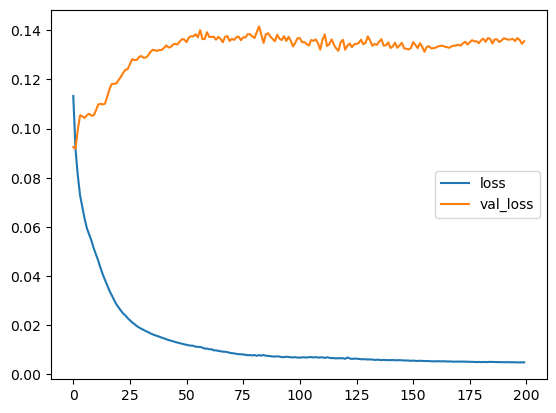

In [99]:
plot_NN_history(results_mlp, validation=True)

1/1 [==============================] - 0s 47ms/step


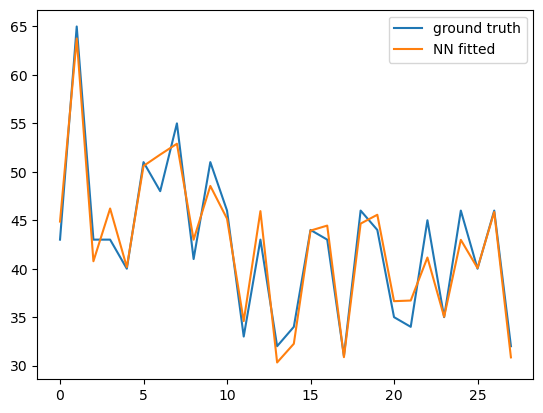

1/1 [==============================] - 0s 9ms/step


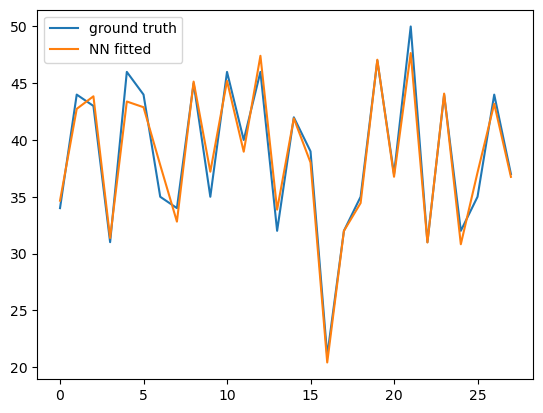

In [100]:
plot_fitted_NN(mlp, X_train, y_train, scaler, index=4)
plot_fitted_NN(mlp, X_train, y_train, scaler, index=5)

In [101]:
nn_eval = cross_validate_NN_preds(mlp, X_test, y_test, scaler=scaler, name='ff_in56_l56_l28')
nn_eval = add_metric_averages(nn_eval)
overall_nn = pd.concat([pd.DataFrame(), nn_eval.iloc[-1]], axis=1)
overall_nn

(1, 56)
1/1 [==============================] - 0s 10ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 8ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/s

ff_in56_l56_l28_avg
MAE                            11.095
MAPE                           22.467
RMSE                           13.764
Coverage_80                       NaN
Coverage_95                       NaN
Winkler_Score_80                  NaN
Winkler_Score_95                  NaN

In [102]:
tf.random.set_seed(2222)

N_EPOCHS = 200
es = EarlyStopping(monitor='loss', patience=10)

#single layer nn
mlp = get_network_model(ws=WINDOW_SIZE,outputs=28, n_neurons_l1=56,
                        include_layer_two=True, n_neurons_l2=28,
                        include_drop_out=True)

#fit model silently
results_mlp = mlp.fit(x=X_train, 
                      y=y_train, 
                      epochs=N_EPOCHS,
                      verbose=0,
#                      callbacks=[es],
                      validation_data= (X_test, y_test))

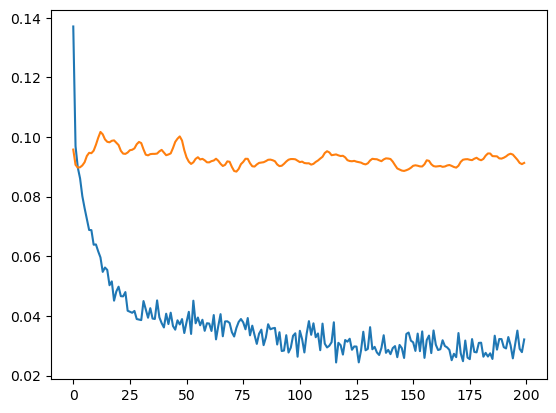

In [103]:
plt.plot(results_mlp.history['loss'], label='loss')
plt.plot(results_mlp.history['val_loss'], label='val_loss')

In [104]:
nn_eval = cross_validate_NN_preds(mlp, X_test, y_test, scaler=scaler, name='ff_in56_l56_l28_lDO')
nn_eval = add_metric_averages(nn_eval)
overall_nn = pd.concat([overall_nn, nn_eval.iloc[-1]], axis=1)
overall_nn.T

(1, 56)
1/1 [==============================] - 0s 26ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/s

MAE    MAPE    RMSE  Coverage_80  Coverage_95  \
ff_in56_l56_l28_avg      11.095  22.467  13.764          NaN          NaN   
ff_in56_l56_l28_lDO_avg   9.934  20.254  12.113          NaN          NaN   

                         Winkler_Score_80  Winkler_Score_95  
ff_in56_l56_l28_avg                   NaN               NaN  
ff_in56_l56_l28_lDO_avg               NaN               NaN

In [105]:
N_EPOCHS = 200
es = EarlyStopping(monitor='loss', patience=10)

#single layer nn
mlp = get_network_model(ws=WINDOW_SIZE,outputs=28, n_neurons_l1=42,
                        include_layer_two=False, include_drop_out=True)

#fit model silently
results_mlp = mlp.fit(x=X_train, 
                      y=y_train, 
                      epochs=N_EPOCHS,
                      verbose=0,
#                      callbacks=[es],
                      validation_data= (X_test, y_test))
nn_eval = cross_validate_NN_preds(mlp, X_test, y_test, scaler=scaler,
                                  name='ff_in56_l42_lDO')
nn_eval = add_metric_averages(nn_eval)
overall_nn = pd.concat([overall_nn, nn_eval.iloc[-1]], axis=1)
overall_nn.T

(1, 56)
1/1 [==============================] - 0s 22ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 8ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/s

MAE    MAPE    RMSE  Coverage_80  Coverage_95  \
ff_in56_l56_l28_avg      11.095  22.467  13.764          NaN          NaN   
ff_in56_l56_l28_lDO_avg   9.934  20.254  12.113          NaN          NaN   
ff_in56_l42_lDO_avg      10.550  21.370  12.921          NaN          NaN   

                         Winkler_Score_80  Winkler_Score_95  
ff_in56_l56_l28_avg                   NaN               NaN  
ff_in56_l56_l28_lDO_avg               NaN               NaN  
ff_in56_l42_lDO_avg                   NaN               NaN

In [106]:
#single layer nn
mlp = get_network_model(ws=WINDOW_SIZE,outputs=28, n_neurons_l1=7,
                        include_layer_two=False, include_drop_out=True)


In [107]:
#fit model silently
results_mlp = mlp.fit(x=X_train, 
                      y=y_train, 
                      epochs=N_EPOCHS,
                      verbose=0,
#                      callbacks=[es],
                      validation_data= (X_test, y_test))
nn_eval = cross_validate_NN_preds(mlp, X_test, y_test, scaler=scaler,
                                  name='ff_in56_l7_lDO')
nn_eval = add_metric_averages(nn_eval)
overall_nn = pd.concat([overall_nn, nn_eval.iloc[-1]], axis=1)
overall_nn.T

(1, 56)
1/1 [==============================] - 0s 22ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/step
(1, 56)
1/1 [==============================] - 0s 9ms/s

MAE    MAPE    RMSE  Coverage_80  Coverage_95  \
ff_in56_l56_l28_avg      11.095  22.467  13.764          NaN          NaN   
ff_in56_l56_l28_lDO_avg   9.934  20.254  12.113          NaN          NaN   
ff_in56_l42_lDO_avg      10.550  21.370  12.921          NaN          NaN   
ff_in56_l7_lDO_avg        9.088  18.491  10.991          NaN          NaN   

                         Winkler_Score_80  Winkler_Score_95  
ff_in56_l56_l28_avg                   NaN               NaN  
ff_in56_l56_l28_lDO_avg               NaN               NaN  
ff_in56_l42_lDO_avg                   NaN               NaN  
ff_in56_l7_lDO_avg                    NaN               NaN

#### 6.3 Fit and Evaluate LSTM <a id='6.3'></a>

In [108]:
WINDOW_SIZE = 56

X_all, y_all = sliding_window_tab(scaled_all, window_size=WINDOW_SIZE,
                                  horizon=28, step=7, lstm=True, add_date_features=True)

X_train, _ = sliding_window_tab(scaled_train_ed, window_size=WINDOW_SIZE,
                                horizon=28, step=7, lstm=True, add_date_features=True)

split_index = len(X_train)

X_train, y_train = X_all[:split_index], y_all[:split_index]

X_test, y_test = X_all[split_index:], y_all[split_index:]

# Print the shape of the training data
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

(135, 56, 4)
(135, 28)
(97, 56, 4)
(97, 28)
Shape of X_train: (97, 56, 4)
Shape of y_train: (97, 28)


In [109]:
# Create the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
lstm_model = create_lstm_model(input_shape, lr=0.1, lstm_activation='tanh')


# Train the model
lstm_results = lstm_model.fit(X_train, y_train, epochs=50,
                              verbose=0, batch_size=32,
                              validation_data=(X_test, y_test),
                             callbacks=es)

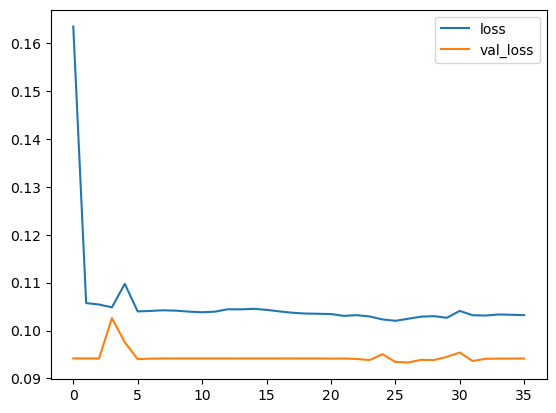

In [110]:
plot_NN_history(lstm_results, validation=True)

1/1 [==============================] - 0s 169ms/step


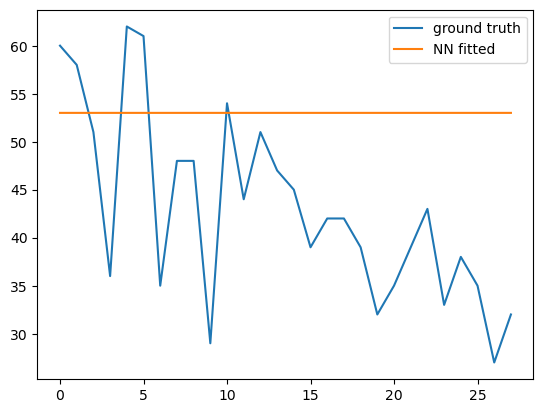

In [111]:
plot_fitted_NN(lstm_model, X_train, y_train, scaler, index=29, lstm_dim=4)

In [112]:
nn_eval = cross_validate_NN_preds(lstm_model, X_test, y_test, scaler=scaler,
                                  name='lstm1', lstm=True)

(1, 56, 4)
1/1 [==============================] - 0s 12ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms/step
(1, 56, 4)
1/1 [==============================] - 0s 9ms/step
(1, 56, 4)
1/1 [==============================] - 0s 9ms/step
(1, 56, 4)
1/1 [==============================] - 0s 10ms

In [113]:
nn_eval = add_metric_averages(nn_eval)

In [114]:
overall_nn = pd.concat([overall_nn, nn_eval.iloc[-1]], axis=1)
overall_nn.T

MAE    MAPE    RMSE  Coverage_80  Coverage_95  \
ff_in56_l56_l28_avg      11.095  22.467  13.764          NaN          NaN   
ff_in56_l56_l28_lDO_avg   9.934  20.254  12.113          NaN          NaN   
ff_in56_l42_lDO_avg      10.550  21.370  12.921          NaN          NaN   
ff_in56_l7_lDO_avg        9.088  18.491  10.991          NaN          NaN   
lstm1_avg                 8.244  18.060   9.872          NaN          NaN   

                         Winkler_Score_80  Winkler_Score_95  
ff_in56_l56_l28_avg                   NaN               NaN  
ff_in56_l56_l28_lDO_avg               NaN               NaN  
ff_in56_l42_lDO_avg                   NaN               NaN  
ff_in56_l7_lDO_avg                    NaN               NaN  
lstm1_avg                             NaN               NaN

# 7. Best Model Future Evaluation <a id='17'></a>

In [115]:
# Initialise an empty DataFrame to store the predictions
all_predictions = pd.DataFrame()

# Iterate through different PIs and PI bounds
for int_width, (upper, lower) in zip([0.95, 0.8],
                                     [['upper_05', 'lower_05'],
                                      ['upper_2', 'lower_2']]):

    print(int_width, upper, lower)

    # Initialise the best performing Prophet model
    rigid_prophet_sa_CP = Prophet(interval_width=int_width,
                                  changepoint_prior_scale=0.005,
                                  yearly_seasonality=15,
                                  changepoints=['2014-12-07', '2015-01-21',
                                                '2016-01-21', '2016-03-14']
                                  )

    # Fit on all data and make predictions
    predictions = (rigid_prophet_sa_CP
                   .fit(prophet_ed)
                   .predict(rigid_prophet_sa_CP
                            .make_future_dataframe(periods=28)
                           )[-28:]
                   .set_index('ds')
                   .loc[:, ['yhat', 'yhat_upper', 'yhat_lower']]
                   .rename({'yhat': 'y_pred',
                            'yhat_upper': upper,
                            'yhat_lower': lower}, axis=1))

    # Concatenate the predictions DataFrame to the overall DataFrame
    all_predictions = pd.concat([all_predictions, predictions], axis=1)

# Remove duplicated 'y_pred' columns
all_predictions = all_predictions.loc[:, ~all_predictions.columns.duplicated()]

final_preds = pd.concat([all_predictions, complete_holdout],axis=1)

# Rename the column to 'y_true'
final_preds.rename({'paed_ed_attends': 'y_true'}, axis=1, inplace=True)




0.95 upper_05 lower_05


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/lt/g5gx9ncd40b1hj431tb2zv240000gn/T/tmp4wg_vlm7/sj8veov3.json
DEBUG:cmdstanpy:input tempfile: /var/folders/lt/g5gx9ncd40b1hj431tb2zv240000gn/T/tmp4wg_vlm7/lmzczuzu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/pavel/anaconda3/envs/hds_code/lib/python3.8/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39519', 'data', 'file=/var/folders/lt/g5gx9ncd40b1hj431tb2zv240000gn/T/tmp4wg_vlm7/sj8veov3.json', 'init=/var/folders/lt/g5gx9ncd40b1hj431tb2zv240000gn/T/tmp4wg_vlm7/lmzczuzu.json', 'output', 'file=/var/folders/lt/g5gx9ncd40b1hj431tb2zv240000gn/T/tmp4wg_vlm7/prophet_model8f_eq3qv/prophet_model-20240216125749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:57:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start proce

0.8 upper_2 lower_2


##### Final Evaluation <a id="final_eval"></a>

In [116]:
evaluate_prediction(final_preds, name='Final').round(3)

MAE    MAPE   RMSE  Coverage_80  Coverage_95  Winkler_Score_80  \
Final  6.578  13.654  7.406        0.714          1.0            23.377   

       Winkler_Score_95  
Final            28.155

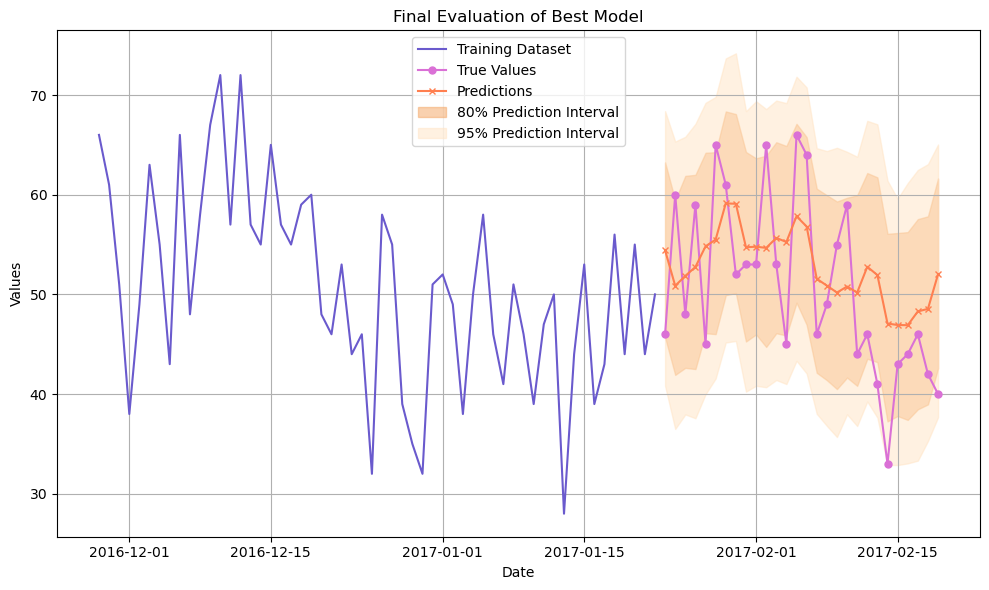

In [117]:
plot_predictions_intervals(final_preds, ed_data[-56:],
                           title='Final Evaluation of Best Model')